In [1]:
#%%
# Python code to produce forecast files
# -*- coding: utf-8 -*-

import numpy as np
import math
import copy
import csv
from IPython.display import display
import sympy
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import matplotlib.transforms as transforms
import matplotlib.animation as animation
import matplotlib as mpl
import camb
import scipy.interpolate as scipy
import scipy.stats as stats
import scipy.cluster as cluster
from astropy.io import fits
from astropy.table import Table
from camb import model, initialpower, symbolic
from camb.sources import GaussianSourceWindow, SplinedSourceWindow

# Code to plot transfer functions from camb

global FILEPATH
#FILEPATH = "/Users/cb607/Documents/Power_Spectrum_Calc"
FILEPATH = "/cosma8/data/dp203/dc-brow6"
# Colourblind friendly colour cycle - Bang Wong, Points of view: Colour Blindness, Nature 8, 441 (2011)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['xkcd:orange','xkcd:sky blue','xkcd:bluish green','xkcd:reddish purple','xkcd:blue','xkcd:vermillion','xkcd:yellow','xkcd:black'])


#############
# FUNCTIONS #
#############

########################
# COSMOLOGY GENERATION #
########################

# retrieves CAMB data for a non massive neutrino universe
def cosmoChangeTotal(Zs, h, omegaM, omegaB, fnu, As=2.105*(10**-9.), ns=0.9665, Neff=3.046, tau=0.06, meffSterile=0.0, hierarchy='normal', w0=-1.0, wa=0.0, kmax=10):
    a = np.zeros((len(Zs)))
    for i in range(len(Zs)):
        a[i] = 1/(Zs[len(Zs)-1-i] + 1)
    a = np.sort(a)
    w_a = np.zeros((len(Zs)))
    for i in range(len(Zs)):
        w_a[i] = w0 + (1-a[i])*wa
    ommh2 = omegaM*h*h
    omnuh2 = fnu*ommh2
    ombh2=omegaB*h*h
    omch2=ommh2-ombh2-omnuh2
    nuMass=omnuh2*93.14
    initPower = camb.InitialPowerLaw()
    initPower.set_params(As=As, ns=ns)
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=h*100, ombh2=ombh2, omch2=omch2, neutrino_hierarchy=hierarchy, 
                        num_massive_neutrinos=3, mnu=nuMass, nnu=Neff, meffsterile=meffSterile, 
                        standard_neutrino_neff=Neff, omk=0, tau=tau)
    pars.set_dark_energy(w=w0, wa=wa, dark_energy_model='ppf')
    pars.set_initial_power(initPower)
    pars.set_initial_power_table(k=cosmoKArray(k_per_logint=300, kmax=kmax))
    pars.set_matter_power(redshifts=Zs, kmax=kmax, k_per_logint=300, nonlinear=None, accurate_massive_neutrino_transfers=True, silent=False)
    params = camb.CAMBdata()
    params.set_params(pars)
    params.calc_transfers(pars)
    data = params.get_matter_transfer_data()
    params.calc_background(pars)
    H_of_z = params.hubble_parameter(Zs)
    return data, H_of_z

def cosmoMatterPowerSpectrum(Zs, h, omegaM, omegaB, fnu, As=2.105*(10**-9.), ns=0.9665, Neff=3.046, tau=0.06, meffSterile=0.0, 
                        hierarchy='normal', w0=-1.0, wa=0.0, kmax=10, logT_AGN=7.8):
    a = np.zeros((len(Zs)))
    for i in range(len(Zs)):
        a[i] = 1/(Zs[len(Zs)-1-i] + 1)
    a = np.sort(a)
    w_a = np.zeros((len(Zs)))
    for i in range(len(Zs)):
        w_a[i] = w0 + (1-a[i])*wa
    ommh2 = omegaM*h*h
    omnuh2 = fnu*ommh2
    ombh2=omegaB*h*h
    omch2=ommh2-ombh2-omnuh2
    nuMass=omnuh2*93.14
    initPower = camb.InitialPowerLaw()
    initPower.set_params(As=As, ns=ns)
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=h*100, ombh2=ombh2, omch2=omch2, neutrino_hierarchy=hierarchy, 
                        num_massive_neutrinos=3, mnu=nuMass, nnu=Neff, meffsterile=meffSterile, 
                        standard_neutrino_neff=Neff, omk=0, tau=tau)
    pars.set_initial_power(initPower)
    pars.set_dark_energy(w=w0, wa=wa, dark_energy_model='ppf')
    #Note non-linear corrections couples to smaller scales than you want
    pars.set_matter_power(redshifts=Zs, kmax=kmax, accurate_massive_neutrino_transfers=True)

    params = camb.CAMBdata()
    params.set_params(pars)
    params.calc_transfers(pars)
    data = params.get_matter_transfer_data()
    kMin = data.transfer_z(name='k/h', z_index=0)[0]

    #Linear spectra
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    kh, z, pk = results.get_matter_power_spectrum(minkh=kMin, maxkh=kmax/h, npoints = 200)
    pk = (np.flip(pk, axis=0))/(h*h*h)

    #Non-Linear spectra (Halofit)
    pars.NonLinear = model.NonLinear_both
    pars.NonLinearModel.set_params(halofit_version='mead2020_feedback', HMCode_logT_AGN=logT_AGN)
    results.calc_power_spectra(pars)
    kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=kMin, maxkh=kmax/h, npoints = 200)
    pk_nonlin = (np.flip(pk_nonlin, axis=0))/(h*h*h)
    pkDiff = pk_nonlin-pk
    PkDiff = []
    k = []
    for i in range(len(kh)):
        k.append(kh[i]*h)
    for i in range(len(Zs)):
        PkDiff.append(scipy.UnivariateSpline(k, pkDiff[i], s=0))
    scaleFactor = []
    for i in range(len(Zs)):
        scaleFactor.append(1./(Zs[i]+1.))
    P_k = []
    P_kNL = []
    for i in range(len(k)):
        P_k.append(scipy.UnivariateSpline(scaleFactor, np.transpose(pk)[i], s=0))
        P_kNL.append(scipy.UnivariateSpline(scaleFactor, np.transpose(pk_nonlin)[i], s=0))
    PkISWDiff = []
    for i in range(len(k)):
        dPk = diffSplineNoData1D(Func=P_k[i], x=scaleFactor, y=np.transpose(pk)[i], dx=1)
        dPkNL = diffSplineNoData1D(Func=P_kNL[i], x=scaleFactor, y=np.transpose(pk_nonlin)[i], dx=1)
        PkISWDiffk = []
        for j in range(len(scaleFactor)):
            PkISW = 2 - dPk[j]
            PkISWNL = 2 - dPkNL[j]
            PkISWDiffk.append(0.5*(PkISWNL - PkISW))
        PkISWDiff.append(PkISWDiffk)
    ISWDiff = []
    for i in range(len(scaleFactor)):
        ISWDiff.append(scipy.UnivariateSpline(k, np.transpose(PkISWDiff)[i], s=0))
    return k, PkDiff, ISWDiff

def cosmoTotalPowerSpectra(Zs, h, omegaM, omegaB, fnu, As=2.105*(10**-9.), ns=0.9665, Neff=3.046, tau=0.06, meffSterile=0.0, 
                        hierarchy='normal', w0=-1.0, wa=0.0, kmax=10, logT_AGN=7.8):
    a = np.zeros((len(Zs)))
    for i in range(len(Zs)):
        a[i] = 1/(Zs[len(Zs)-1-i] + 1)
    a = np.sort(a)
    w_a = np.zeros((len(Zs)))
    for i in range(len(Zs)):
        w_a[i] = w0 + (1-a[i])*wa
    ommh2 = omegaM*h*h
    omnuh2 = fnu*ommh2
    ombh2=omegaB*h*h
    omch2=ommh2-ombh2-omnuh2
    nuMass=omnuh2*93.14
    initPower = camb.InitialPowerLaw()
    initPower.set_params(As=As, ns=ns)
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=h*100, ombh2=ombh2, omch2=omch2, neutrino_hierarchy=hierarchy, 
                        num_massive_neutrinos=3, mnu=nuMass, nnu=Neff, meffsterile=meffSterile, 
                        standard_neutrino_neff=Neff, omk=0, tau=tau)
    pars.set_initial_power(initPower)
    pars.set_dark_energy(w=w0, wa=wa, dark_energy_model='ppf')
    #Note non-linear corrections couples to smaller scales than you want
    pars.set_matter_power(redshifts=Zs, kmax=kmax, accurate_massive_neutrino_transfers=True)
    params = camb.CAMBdata()
    params.set_params(pars)
    params.calc_transfers(pars)
    data = params.get_matter_transfer_data()
    kMin = data.transfer_z(name='k/h', z_index=0)[0]
    params.calc_background(pars)
    H_of_z = params.hubble_parameter(Zs)

    #Non-Linear spectra (Halofit)
    pars.NonLinear = model.NonLinear_both
    results = camb.get_results(pars)
    pars.NonLinearModel.set_params(halofit_version='mead2020_feedback', HMCode_logT_AGN=logT_AGN)
    results.calc_power_spectra(pars)
    kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=kMin, maxkh=kmax/h, npoints = 200)
    kh_nonlinWeyl, z_nonlinWeyl, pk_nonlinWeyl = results.get_matter_power_spectrum(minkh=kMin, maxkh=kmax/h, npoints = 200, var1="Weyl", var2="Weyl")
    pk_nonlin = (np.flip(pk_nonlin, axis=0))/(h*h*h)
    pk_nonlinWeyl = (np.flip(pk_nonlinWeyl, axis=0))/(h*h*h)
    k = []
    for i in range(len(kh_nonlin)):
        k.append(kh_nonlin[i]*h)
    scaleFactor = []
    for i in range(len(Zs)):
        scaleFactor.append(1./(Zs[i]+1.))
    PkNL = []
    Weyl = []
    for i in range(len(Zs)):
        PkNL.append(scipy.UnivariateSpline(k, pk_nonlin[i], s=0))
        Weyl.append(scipy.UnivariateSpline(k, pk_nonlinWeyl[i], s=0))
    P_kNL = []
    for i in range(len(k)):
        P_kNL.append(scipy.UnivariateSpline(scaleFactor, np.transpose(pk_nonlin)[i], s=0))
    PkISW = []
    for i in range(len(k)):
        dPkNL = diffSplineNoData1D(Func=P_kNL[i], x=scaleFactor, y=np.transpose(pk_nonlin)[i], dx=1)
        PkISWk = []
        for j in range(len(scaleFactor)):
            PkISWNL = 2 - dPkNL[j]
            PkISWk.append(0.5*(PkISWNL))
        PkISW.append(PkISWk)
    ISW = []
    for i in range(len(scaleFactor)):
        ISW.append(scipy.UnivariateSpline(k, np.transpose(PkISW)[i], s=0))
    return k, PkNL, ISW, Weyl, data, H_of_z

def cosmoKArray(k_per_logint, kmax, kinit=5e-6):
    k = []
    ki = np.log10(kinit)
    kf = np.log10((kmax)+(kmax/10.))
    size = int(round((kf-ki)*k_per_logint))
    increment = (kf-ki)/size
    for i in range(size):
        k.append(kinit*10**(i*increment))
    return np.asarray(k)


##################################
# DATASET RETRIEVAL/MANIPULATION #
##################################

# Combine data sets and sort, ignoring the last value of High (for avoiding repeating normalisation purposes)
def combineDataSet(Low, High):
    D = []
    for i in range(0, len(Low)):
        D.append(Low[i])
    for i in range(0, (len(High)-1)):
        D.append(High[i])
    D.sort()
    return D


####################
# SPLINE FUNCTIONS #
####################


# dlogF/dloga
def diffSplineNoData1D(Func, x, y, dx=1):
    Fderiv = Func.derivative(n=dx)
    F = Fderiv(x)
    G = []
    for i in range(0, len(x)):
        G.append(x[i]*F[i]/y[i])
    return G



#########################
# INPUT FILE GENERATION #
#########################

# Main function to generate input files
def spectraForecasting(loZ, hiZ, scaleFactor, telescope="4MOST", geometricMean=False, growthFunction=False, 
                        inputSuffix=""):
    # loZ, hiZ: Near redshift and far redshift ranges. 
    #           CAMB uses a limited range of redshift values, so split appropriately
    # scaleFactor: Above redshifts in scale factor. Will later deprecate to only need either redshift or scale factor.
    # telescope: Which telescope model to follow. Choice of:
    #               DES - Dark Energy Survey galaxy spectra, using photo-z smearing
    #               Toy Model - Alternative photo-z smearing using Gaussian convolved galaxy spectra
    #               4MOST - Specto-z galaxy spectra using 4MOST Facility Simulation data. Needs access to 4FS data.
    # geometricMean: Switches from transfer function power spectra to geometric mean power spectra. Uncompatible
    #                with growthFunction=True.
    # growthFunction: Switches from scale-dependent transfer function growth to large-scale growth only.
    #                 Uncompatible with geometricMean=True.

    if(geometricMean==growthFunction and geometricMean==True):
        print("Geometric Mean and Growth function calculation not yet implemented. Switching to base calculation.")
        geometricMean=False
        growthFunction=False
    # Planck+BAO 2018 legacy results
    devMult = 1.0   # parameter to tune deviation of parameters
    planckh = 0.6766
    hDev = devMult*0.01
    planckAs = 2.105*(10**-9.)
    AsDev = devMult*0.1*(10**-9.)
    planckns = 0.9665
    nsDev = devMult*0.1
    planckOmM = 0.3111
    OmMDev = devMult*0.01
    planckOmB = 0.02242/(planckh*planckh)
    OmBDev = devMult*0.001/(planckh*planckh)
    # normal hierarchy lower limit is 0.06eV / inverted hierarchy lower limit is 0.1eV
    planckfnu = 0.12/(93.14*planckOmM*planckh*planckh)
    fnuDev = devMult*0.05/(93.14*planckOmM*planckh*planckh)
    # use theoretical 3.046
    planckNeff = 3.046
    NeffDev = 0.1
    plancktau = 0.0561
    tauDev = 0.05
    planckw0=-1.0
    w0Dev=devMult*0.1
    planckwa=0.0
    waDev=devMult*0.1
    logT_AGN=7.8    # BAO-feedback parameter for HMCode
    logT_AGNDev=devMult*logT_AGN/10
    
    # 4MOST Bias
    if(telescope != "DES" and telescope != "Toy Model"):
        # BIAS parameters b(z) = c + (b-c)/(D(z)**alpha)
        # A perscription for galaxy biasing evolution as a nuisance parameter
        # L Clerkin, et al.
        b=[1.285, 1.549, 1.488, 1.349, 1.349]
        bdev=[b[0]/10.0, b[1]/10.0, b[2]/10.0, b[3]/10.0, b[4]/10.0]
        c=[1.0, 1.0, 1.0, 1.0, 1.0]
        cdev=[c[0]/10.0, c[1]/10.0, c[2]/10.0, c[3]/10.0, c[4]/10.0]
        alpha=[1.0, 1.0, 1.0, 1.0, 1.0]
        alphadev=[alpha[0]/10.0, alpha[1]/10.0, alpha[2]/10.0, alpha[3]/10.0, alpha[4]/10.0]
    
    # DES/Toy Model bias
    else:
        # b(z) = b; i.e. constant bias across bin
        b=[1.5, 1.8, 1.8, 1.9, 2.3, 2.3]
        bdev=[devMult*b[0]/10.0, devMult*b[1]/10.0, devMult*b[2]/10.0, devMult*b[3]/10.0, devMult*b[4]/10.0, devMult*b[5]/10.0]
        sigmab = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05]   # reduce this to reduce photo-z effects
        sigmabdev = [devMult*sigmab[0]/10., devMult*sigmab[1]/10., devMult*sigmab[2]/10., devMult*sigmab[3]/10., devMult*sigmab[4]/10., devMult*sigmab[5]/10.]
        cb = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]     # Additional photo-z param. Set to 0 to remove.
        cbdev = [devMult*0.1, devMult*0.1, devMult*0.1, devMult*0.1, devMult*0.1, devMult*0.1]
        # Not necessary, kept to maintain functionality
        c=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
        cdev=[c[0]/10.0, c[1]/10.0, c[2]/10.0, c[3]/10.0, c[4]/10.0, c[5]/10.0]
        alpha=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
        alphadev=[alpha[0]/10.0, alpha[1]/10.0, alpha[2]/10.0, alpha[3]/10.0, alpha[4]/10.0, alpha[5]/10.0]
    # Intrinsic Alignment params
    AIA = [1.0, 1.0, 1.0, 1.0]
    AIADev = [devMult*0.1, devMult*0.1, devMult*0.1, devMult*0.1]
    etaIA = [0.0, 0.0, 0.0, 0.0]
    etaIADev = [devMult*0.1, devMult*0.1, devMult*0.1, devMult*0.1]
    zpivot = 0.3
    C1RhoCr = 0.0134
    
    # Weak Lensing source galaxy selection functions
    if(telescope=="Toy Model"):     # Toy Model WL selection functions undergo smearing too
        WL1 = GaussianGalaxyBin(redshift=fullRedshift, zLo=0.01, zHi=0.36, zMed=0.185, photo=True, sigmab=sigmab[0])
        WL2 = GaussianGalaxyBin(redshift=fullRedshift, zLo=0.36, zHi=0.63, zMed=0.495, photo=True, sigmab=sigmab[1])
        WL3 = GaussianGalaxyBin(redshift=fullRedshift, zLo=0.63, zHi=0.87, zMed=0.75, photo=True, sigmab=sigmab[2])
        WL4 = GaussianGalaxyBin(redshift=fullRedshift, zLo=0.87, zHi=2.0, zMed=1.435, photo=True, sigmab=sigmab[3])
        sourceSelectionFuncs = np.array([WL1, WL2, WL3, WL4])
    else:    # DES provides WL selection functions for both 4MOST and DES forecasts
        WL1 = DESSelectionFunction(redshift=fullRedshift, zLo=0.01, zHi=0.36, zMed=0.75)
        WL2 = DESSelectionFunction(redshift=fullRedshift, zLo=0.36, zHi=0.63, zMed=0.75)
        WL3 = DESSelectionFunction(redshift=fullRedshift, zLo=0.63, zHi=0.87, zMed=0.75)
        WL4 = DESSelectionFunction(redshift=fullRedshift, zLo=0.87, zHi=2.0, zMed=0.75)
        sourceSelectionFuncs = np.array([WL1, WL2, WL3, WL4])
    print("Source limits:")
    print(round(min(fullRedshift[WL1/max(WL1) > 0.01]), 2))
    print(round(max(fullRedshift[WL1/max(WL1) > 0.01]), 2))
    print(round(min(fullRedshift[WL2/max(WL2) > 0.01]), 2))
    print(round(max(fullRedshift[WL2/max(WL2) > 0.01]), 2))
    print(round(min(fullRedshift[WL3/max(WL3) > 0.01]), 2))
    print(round(max(fullRedshift[WL3/max(WL3) > 0.01]), 2))
    print(round(min(fullRedshift[WL4/max(WL4) > 0.01]), 2))
    print(round(max(fullRedshift[WL4/max(WL4) > 0.01]), 2))
    # Weak Lensing source galaxy bin limits:
    # [0.2, 0.4, 0.55, 0.7, 0.85, 0.95, 1.05] Original (pre-smearing)
    # [[0.11, 0.63], [0.26, 0.78], [0.39, 0.93], [0.51, 1.09], [0.63, 1.21], [0.71, 1.31]] 98% bins (post-smearing)

    # Galaxy Clustering galaxy selection functions
    # DES galaxy selection functions
    if(telescope=="DES"):
        DES1 = DESSelectionFunction(redshift=fullRedshift, zLo=0.2, zHi=0.4, zMed=0.5)
        DES2 = DESSelectionFunction(redshift=fullRedshift, zLo=0.4, zHi=0.55, zMed=0.5)
        DES3 = DESSelectionFunction(redshift=fullRedshift, zLo=0.55, zHi=0.7, zMed=0.5)
        DES4 = DESSelectionFunction(redshift=fullRedshift, zLo=0.7, zHi=0.85, zMed=0.5)
        DES5 = DESSelectionFunction(redshift=fullRedshift, zLo=0.85, zHi=0.95, zMed=0.5)
        DES6 = DESSelectionFunction(redshift=fullRedshift, zLo=0.95, zHi=1.05, zMed=0.5)
        print("Lens limits:")
        print(round(min(fullRedshift[DES1/max(DES1) > 0.01]), 2))
        print(round(max(fullRedshift[DES1/max(DES1) > 0.01]), 2))
        print(round(min(fullRedshift[DES2/max(DES2) > 0.01]), 2))
        print(round(max(fullRedshift[DES2/max(DES2) > 0.01]), 2))
        print(round(min(fullRedshift[DES3/max(DES3) > 0.01]), 2))
        print(round(max(fullRedshift[DES3/max(DES3) > 0.01]), 2))
        print(round(min(fullRedshift[DES4/max(DES4) > 0.01]), 2))
        print(round(max(fullRedshift[DES4/max(DES4) > 0.01]), 2))
        print(round(min(fullRedshift[DES5/max(DES5) > 0.01]), 2))
        print(round(max(fullRedshift[DES5/max(DES5) > 0.01]), 2))
        print(round(min(fullRedshift[DES6/max(DES6) > 0.01]), 2))
        print(round(max(fullRedshift[DES6/max(DES6) > 0.01]), 2))
        selectionFuncs = np.array([DES1, DES2, DES3, DES4, DES5, DES6])
        plt.axvspan(0.2, 0.4, alpha=0.5, color="xkcd:orange")
        plt.plot(fullRedshift, DES1, color="xkcd:orange", label="DES1")
        plt.axvspan(0.4, 0.55, alpha=0.5, color="xkcd:sky blue")
        plt.plot(fullRedshift, DES2, color="xkcd:sky blue", label="DES2")
        plt.axvspan(0.55, 0.7, alpha=0.5, color="xkcd:bluish green")
        plt.plot(fullRedshift, DES3, color="xkcd:bluish green", label="DES3")
        plt.axvspan(0.7, 0.85, alpha=0.5, color="xkcd:reddish purple")
        plt.plot(fullRedshift, DES4, color="xkcd:reddish purple", label="DES4")
        plt.axvspan(0.85, 0.95, alpha=0.5, color="xkcd:blue")
        plt.plot(fullRedshift, DES5, color="xkcd:blue", label="DES5")
        plt.axvspan(0.95, 1.05, alpha=0.5, color="xkcd:vermillion")
        plt.plot(fullRedshift, DES6, color="xkcd:vermillion", label="DES6")
        plt.xlabel("Redshift")
        plt.xlim([0.0,2.0])
        plt.ylabel("1/N dN/dz")
        plt.legend()
        plt.show()

    # Toy Model galaxy selection functions
    elif(telescope=="Toy Model"):
        DES1 = GaussianGalaxyBin(redshift=fullRedshift, zLo=0.2, zHi=0.4, zMed=0.3, photo=True, sigmab=sigmab[0])
        DES2 = GaussianGalaxyBin(redshift=fullRedshift, zLo=0.4, zHi=0.55, zMed=0.475, photo=True, sigmab=sigmab[1])
        DES3 = GaussianGalaxyBin(redshift=fullRedshift, zLo=0.55, zHi=0.7, zMed=0.625, photo=True, sigmab=sigmab[2])
        DES4 = GaussianGalaxyBin(redshift=fullRedshift, zLo=0.7, zHi=0.85, zMed=0.775, photo=True, sigmab=sigmab[3])
        DES5 = GaussianGalaxyBin(redshift=fullRedshift, zLo=0.85, zHi=0.95, zMed=0.9, photo=True, sigmab=sigmab[4])
        DES6 = GaussianGalaxyBin(redshift=fullRedshift, zLo=0.95, zHi=1.05, zMed=1.0, photo=True, sigmab=sigmab[5])
        print("Lens limits:")
        print(round(min(fullRedshift[DES1/max(DES1) > 0.01]), 2))
        print(round(max(fullRedshift[DES1/max(DES1) > 0.01]), 2))
        print(round(min(fullRedshift[DES2/max(DES2) > 0.01]), 2))
        print(round(max(fullRedshift[DES2/max(DES2) > 0.01]), 2))
        print(round(min(fullRedshift[DES3/max(DES3) > 0.01]), 2))
        print(round(max(fullRedshift[DES3/max(DES3) > 0.01]), 2))
        print(round(min(fullRedshift[DES4/max(DES4) > 0.01]), 2))
        print(round(max(fullRedshift[DES4/max(DES4) > 0.01]), 2))
        print(round(min(fullRedshift[DES5/max(DES5) > 0.01]), 2))
        print(round(max(fullRedshift[DES5/max(DES5) > 0.01]), 2))
        print(round(min(fullRedshift[DES6/max(DES6) > 0.01]), 2))
        print(round(max(fullRedshift[DES6/max(DES6) > 0.01]), 2))
        selectionFuncs = np.array([DES1, DES2, DES3, DES4, DES5, DES6])
        plt.axvspan(0.2, 0.4, alpha=0.5, color="xkcd:orange")
        plt.plot(fullRedshift, DES1, color="xkcd:orange", label="DES1")
        plt.axvspan(0.4, 0.55, alpha=0.5, color="xkcd:sky blue")
        plt.plot(fullRedshift, DES2, color="xkcd:sky blue", label="DES2")
        plt.axvspan(0.55, 0.7, alpha=0.5, color="xkcd:bluish green")
        plt.plot(fullRedshift, DES3, color="xkcd:bluish green", label="DES3")
        plt.axvspan(0.7, 0.85, alpha=0.5, color="xkcd:reddish purple")
        plt.plot(fullRedshift, DES4, color="xkcd:reddish purple", label="DES4")
        plt.axvspan(0.85, 0.95, alpha=0.5, color="xkcd:blue")
        plt.plot(fullRedshift, DES5, color="xkcd:blue", label="DES5")
        plt.axvspan(0.95, 1.05, alpha=0.5, color="xkcd:vermillion")
        plt.plot(fullRedshift, DES6, color="xkcd:vermillion", label="DES6")
        plt.xlabel("Redshift")
        plt.xlim([0.0,2.0])
        plt.ylabel("1/N dN/dz")
        plt.legend()
        plt.show()

    # 4MOST galaxy selection functions
    else:
        # Retrieve data
        binsGal = np.arange(0.0, 5.05, 0.05)
        binsQSO = np.arange(0.0, 5.05, 0.05)
        #                                           /Users/cb607/Documents/Power_Spectrum_Calc
        BG, BGCenters = readInFITS(filename=FILEPATH+'/4fsClusteringData/CleanedData/output_reduced_BG.fits', bins=binsGal)
        LRG, LRGCenters = readInFITS(filename=FILEPATH+'/4fsClusteringData/CleanedData/output_reduced_LRG.fits', bins=binsGal)
        ELG, ELGCenters = readInFITS(filename=FILEPATH+'/4fsClusteringData/CleanedData/output_reduced_ELG.fits', bins=binsGal)
        QSO, QSOCenters = readInFITS(filename=FILEPATH+'/4fsClusteringData/CleanedData/output_reduced_QSO.fits', bins=binsQSO, useEstimate=True)
        LyA, LyACenters = readInFITS(filename=FILEPATH+'/4fsClusteringData/CleanedData/output_reduced_LyA.fits', bins=binsQSO, useEstimate=True)
        plt.xlabel("Redshift")
        plt.ylabel("Galaxy counts")
        plt.show()
        # Combine Quasar datasets
        QSOLyA = np.zeros(len(QSOCenters))
        for i in range(len(QSOLyA)):
            QSOLyA[i] = QSO[i]+LyA[i]
        # Retrieve galaxy totals
        BGTot = np.sum(BG)
        LRGTot = np.sum(LRG)
        ELGTot = np.sum(ELG)
        QSOTot = np.sum(QSO)
        LyATot = np.sum(LyA)
        # 1/N DN/Dz
        BGSpline = scipy.UnivariateSpline(BGCenters, BG/(BGTot*0.05), s=0)
        LRGSpline = scipy.UnivariateSpline(LRGCenters, LRG/(LRGTot*0.05), s=0)
        ELGSpline = scipy.UnivariateSpline(ELGCenters, ELG/(ELGTot*0.05), s=0)
        QSOSpline = scipy.UnivariateSpline(QSOCenters, QSO/(QSOTot*0.05), s=0)
        LyASpline = scipy.UnivariateSpline(LyACenters, LyA/(LyATot*0.05), s=0)
        # Create type-specific redshifts that correspond to each galaxy
        redshiftBG = []
        redshiftLRG = []
        redshiftELG = []
        redshiftQSO = []
        redshiftLyA = []
        BGSelectionFuncBool = np.zeros(len(scaleFactor), dtype=bool)
        LRGSelectionFuncBool = np.zeros(len(scaleFactor), dtype=bool)
        ELGSelectionFuncBool = np.zeros(len(scaleFactor), dtype=bool)
        QSOSelectionFuncBool = np.zeros(len(scaleFactor), dtype=bool)
        LyASelectionFuncBool = np.zeros(len(scaleFactor), dtype=bool)
        for i in range(len(scaleFactor)):
            z = (1./scaleFactor[(len(scaleFactor))-i-1])-1.
            # if within type distribution
            if(z>BGCenters[0] and z<BGCenters[len(BGCenters)-1]):
                redshiftBG.append(z)
                BGSelectionFuncBool[i] = True
            if(z>LRGCenters[0] and z<LRGCenters[len(LRGCenters)-1]):
                redshiftLRG.append(z)
                LRGSelectionFuncBool[i] = True
            if(z>ELGCenters[0] and z<ELGCenters[len(ELGCenters)-1]):
                redshiftELG.append(z)
                ELGSelectionFuncBool[i] = True
            if(z>QSOCenters[0] and z<QSOCenters[len(QSOCenters)-1]):
                redshiftQSO.append(z)
                QSOSelectionFuncBool[i] = True
            if(z>LyACenters[0] and z<LyACenters[len(LyACenters)-1]):
                redshiftLyA.append(z)
                LyASelectionFuncBool[i] = True
        # Output spline values for provided redshift distribution
        dBGsection = BGSpline(redshiftBG)
        dLRGsection = LRGSpline(redshiftLRG)
        dELGsection = ELGSpline(redshiftELG)
        dQSOsection = QSOSpline(redshiftQSO)
        dLyAsection = LyASpline(redshiftLyA)
        # Move results in full arrays that follow the redshift distribution
        dBG = np.zeros(len(scaleFactor))
        dLRG = np.zeros(len(scaleFactor))
        dELG = np.zeros(len(scaleFactor))
        dQSO = np.zeros(len(scaleFactor))
        dLyA = np.zeros(len(scaleFactor))
        fullRedshift = np.zeros(len(scaleFactor))
        firstTimeBG = True
        elementTrackerBG = 0
        firstTimeLRG = True
        elementTrackerLRG = 0
        firstTimeELG = True
        elementTrackerELG = 0
        firstTimeQSO = True
        elementTrackerQSO = 0
        firstTimeLyA = True
        elementTrackerLyA = 0
        for i in range(len(scaleFactor)):
            fullRedshift[i] = (1./scaleFactor[(len(scaleFactor))-i-1])-1.
            if(BGSelectionFuncBool[i]):
                if(firstTimeBG==True): # Set the offset between the section and the full array
                    firstTimeBG = False
                    elementTrackerBG=i
                dBG[i] = dBGsection[i-elementTrackerBG]
            if(LRGSelectionFuncBool[i]):
                if(firstTimeLRG==True): # Set the offset between the section and the full array
                    firstTimeLRG = False
                    elementTrackerLRG=i
                dLRG[i] = dLRGsection[i-elementTrackerLRG]
            if(ELGSelectionFuncBool[i]):
                if(firstTimeELG==True): # Set the offset between the section and the full array
                    firstTimeELG = False
                    elementTrackerELG=i
                dELG[i] = dELGsection[i-elementTrackerELG]
            if(QSOSelectionFuncBool[i]):
                if(firstTimeQSO==True): # Set the offset between the section and the full array
                    firstTimeQSO = False
                    elementTrackerQSO=i
                dQSO[i] = dQSOsection[i-elementTrackerQSO]
            if(LyASelectionFuncBool[i]):
                if(firstTimeLyA==True): # Set the offset between the section and the full array
                    firstTimeLyA = False
                    elementTrackerLyA=i
                dLyA[i] = dLyAsection[i-elementTrackerLyA]
        selectionFuncs = np.array([dBG, dLRG, dELG, dQSO, dLyA])
        plt.plot(fullRedshift, dBG, label="BG")
        plt.plot(fullRedshift, dLRG, label="LRG")
        plt.plot(fullRedshift, dELG, label="ELG")
        plt.plot(fullRedshift, dQSO, label="QSO")
        plt.plot(fullRedshift, dLyA, label="LyA")
        plt.xlabel("Redshift")
        plt.xlim([0.0, 4.0])
        plt.ylabel("1/N dN/dz")
        plt.legend()
        plt.show()
    
    # DES+DES parameters
    if(telescope=="DES"):
        paramNames = ["h","OmM","OmB","fnu","Neff","As","ns","tau","w0","wa","logT_AGN","b0","b1","b2","b3","b4","b5","numDen0","numDen1","numDen2","numDen3","numDen4","numDen5","sigmab0","sigmab1","sigmab2","sigmab3","sigmab4","sigmab5","cb0","cb1","cb2","cb3","cb4","cb5","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3"]
    # Toy model parameters // photometric
    elif(telescope=="Toy Model"):
        paramNames = ["h","OmM","OmB","fnu","Neff","As","ns","tau","w0","wa","logT_AGN","b0","b1","b2","b3","b4","b5","numDen0","numDen1","numDen2","numDen3","numDen4","numDen5","sigmab0","sigmab1","sigmab2","sigmab3","sigmab4","sigmab5","Ssigmab0","Ssigmab1","Ssigmab2","Ssigmab3","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3"]
    # 4MOST+DES parameters
    else:
        paramNames = ["h","OmM","OmB","fnu","Neff","As","ns","tau","w0","wa","logT_AGN","b0","b1","b2","b3","b4","c0","c1","c2","c3","c4","alpha0","alpha1","alpha2","alpha3","alpha4","numDen0","numDen1","numDen2","numDen3","numDen4","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3"]
    hInfo = ["h_value_dev.:", planckh, hDev]
    # Galaxy bin name, survey sky fraction, number density, numden. deviation, lower bin lim, upper bin lim, bin centre, file suffix
    # DES MagLim lens galaxy sample using "Gold" catalogue surface area
    # [0.2, 0.4, 0.55, 0.7, 0.85, 0.95, 1.05] Original
    # [[0.11, 0.63], [0.26, 0.78], [0.39, 0.93], [0.51, 1.09], [0.63, 1.21], [0.71, 1.31]] 98% bins
    if(telescope=="DES"):
        galZBins = [["1", 0.1818*(4946/7500), 0.154*60*60, 0.0154*60*60, 0.11, 0.63, 0.5, "DES1"],
                    ["2", 0.1818*(4946/7500), 0.115*60*60, 0.0115*60*60, 0.26, 0.78, 0.5, "DES2"],
                    ["3", 0.1818*(4946/7500), 0.115*60*60, 0.0115*60*60, 0.39, 0.93, 0.5, "DES3"],
                    ["4", 0.1818*(4946/7500), 0.154*60*60, 0.0154*60*60, 0.51, 1.09, 0.5, "DES4"],
                    ["5", 0.1818*(4946/7500), 0.117*60*60, 0.0117*60*60, 0.63, 1.21, 0.5, "DES5"],
                    ["6", 0.1818*(4946/7500), 0.113*60*60, 0.0113*60*60, 0.71, 1.31, 0.5, "DES6"]]
        galBinLimits = [0.2, 0.4, 0.55, 0.7, 0.85, 0.95, 1.05]
    
    # Toy model lens galaxy sample // photometric
    # [0.2, 0.4, 0.55, 0.7, 0.85, 0.95, 1.05] Original
    # [[0.15, 0.45], [0.36, 0.58], [0.52, 0.73], [0.67, 0.88], [0.83, 0.97], [0.93, 1.06]] 98% bins
    elif(telescope=="Toy Model"):
        galZBins = [["1", 0.1818*(4946/7500), 0.154*60*60, 0.0154*60*60, 0.15, 0.45, 0.3, "DES1"],
                    ["2", 0.1818*(4946/7500), 0.115*60*60, 0.0115*60*60, 0.36, 0.58, 0.475, "DES2"],
                    ["3", 0.1818*(4946/7500), 0.115*60*60, 0.0115*60*60, 0.52, 0.73, 0.625, "DES3"],
                    ["4", 0.1818*(4946/7500), 0.154*60*60, 0.0154*60*60, 0.67, 0.88, 0.775, "DES4"],
                    ["5", 0.1818*(4946/7500), 0.117*60*60, 0.0117*60*60, 0.83, 0.97, 0.9, "DES5"],
                    ["6", 0.1818*(4946/7500), 0.113*60*60, 0.0113*60*60, 0.93, 1.06, 1.0, "DES6"]]
        galBinLimits = [0.2, 0.4, 0.55, 0.7, 0.85, 0.95, 1.05]
    # 4MOST galaxy clustering sample
    else:
        galZBins = [["BG", 0.1818, 250, 25, 0.15, 0.4, 0.275, "4MOST1"],
                    ["LRG", 0.1818, 400, 40, 0.4, 0.7, 0.55, "4MOST2"],
                    ["ELG", 0.1818/7.5, 1200, 120, 0.6, 1.1, 0.85, "4MOST3"],
                    ["QSO", 0.1818, 190, 19, 0.9, 2.2, 1.55, "4MOST4"],
                    ["QSO-Lya", 0.1818, 50, 5, 2.2, 3.5, 2.85, "4MOST5"]]
    
    if(telescope=="Toy Model"):
        lensZBins = [["g", 0.1818*(4143/7500), 5472, 547.2, 0.01, 0.53, 0.185, "DES1"],
                    ["r", 0.1818*(4143/7500), 5580, 558, 0.22, 0.83, 0.495, "DES2"],
                    ["i", 0.1818*(4143/7500), 5868, 586.8, 0.47, 1.11, 0.75, "DES3"],
                    ["z", 0.1818*(4143/7500), 2988, 298.8, 0.55, 2.41, 1.435, "DES4"]]
        lensBinLimits = [0.01, 0.36, 0.63, 0.87, 2.0]
    else:
        lensZBins = [["g", 0.1818*(4143/7500), 5472, 547.2, 0.01, 0.36, 0.75, "DES1"],
                    ["r", 0.1818*(4143/7500), 5580, 558, 0.36, 0.63, 0.75, "DES2"],
                    ["i", 0.1818*(4143/7500), 5868, 586.8, 0.63, 0.87, 0.75, "DES3"],
                    ["z", 0.1818*(4143/7500), 2988, 298.8, 0.87, 2.0, 0.75, "DES4"]]
        lensBinLimits = [0.01, 0.36, 0.63, 0.87, 2.0]
    
    # Used by C++ code to assign instruments to kernels
    kernelInstruments = [0, 0, 1, 1, 3, 3]
    # List of observables to compute (Note: CMBLense remains for functionality but will be deprecated)
    observableNames = ["ISWISW", "TempGal", "GalGal", "CMBLenseTemp", "CMBLenseCMBLense", "CMBLenseGal", "GravGrav",
                        "GravIntAlign", "IntAlignIntAlign", "GalLenseGrav", "GalLenseIntAlign","CMBLenseGrav",
                        "CMBLenseIntAlign", "TempGrav", "TempIntAlign"]
    # Links angular power spectra to kernel instruments
    observableKernels = [[2,0,0,0,0,0],[1,0,1,0,0,0],[0,0,2,0,0,0],[1,1,0,0,0,0],[0,2,0,0,0,0],[0,1,1,0,0,0],[0,0,0,0,2,0],
                        [0,0,0,0,1,1],[0,0,0,0,0,2],[0,0,0,1,1,0],[0,0,0,1,0,1],[0,1,0,0,1,0],[0,1,0,0,0,1],[1,0,0,0,1,0],
                        [1,0,0,0,0,1]]
    # Makes parameterFile to be read by C++ code
    outputParameterFile(paramNames=paramNames, hInfo=hInfo, galZBins=galZBins, lensZBins=lensZBins, calcBinCrossCov=1, observableNames=observableNames,
                        observableKernels=observableKernels, kernelInstruments=kernelInstruments, suffix=inputSuffix)
    print("Parameter file done.")
    # BASE COSMOLOGY
    # mean result
    if(geometricMean):
        scaleFactor, K, Pk, PkISW, PkWeyl, P, H_of_z, h, fNu, omegaM, bias, IAKernel, Tm = outputAllGeoMeanSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, fNu=planckfnu, 
                        Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa, b=b, c=c, alpha=alpha, AIA=AIA, 
                        etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                        sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"Mean",
                        telescope=telescope)
    else:
        scaleFactor, K, T_c, T_b, T_nu, T_Weyl, dT_c, dT_b, dT_nu, P, H_of_z, h, fNu, omegaM, omegaB, bias, IAKernel, PkDiff, ISWDiff, Tm = outputAllSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, fNu=planckfnu, 
                        Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa, b=b, c=c, alpha=alpha, AIA=AIA, 
                        etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                        sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"Mean",
                        telescope=telescope, growthFunction=growthFunction)
    print("Mean done.")
    # h deviations
    if(geometricMean):
        outputAllGeoMeanSpectra(h=planckh+hDev, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa, b=b, c=c, alpha=alpha, 
                    AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, selectionFuncs=selectionFuncs, suffix=inputSuffix+"h+",
                    telescope=telescope)
        outputAllGeoMeanSpectra(h=planckh-hDev, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa, b=b, c=c, alpha=alpha, 
                    AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, selectionFuncs=selectionFuncs, suffix=inputSuffix+"h-",
                    telescope=telescope)
    else:
        outputAllSpectra(h=planckh+hDev, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa, b=b, c=c, alpha=alpha, 
                    AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"h+",
                    telescope=telescope, growthFunction=growthFunction)
        outputAllSpectra(h=planckh-hDev, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa, b=b, c=c, alpha=alpha, 
                    AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"h-",
                    telescope=telescope, growthFunction=growthFunction)
    print("h done.")
    # As deviations
    if(geometricMean):
        outputAllGeoMeanSpectra(h=planckh, As=planckAs+AsDev, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa, b=b, c=c, alpha=alpha, 
                    AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, selectionFuncs=selectionFuncs, suffix=inputSuffix+"As+",
                    telescope=telescope)
        outputAllGeoMeanSpectra(h=planckh, As=planckAs-AsDev, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa, b=b, c=c, alpha=alpha, 
                    AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, selectionFuncs=selectionFuncs, suffix=inputSuffix+"As-",
                    telescope=telescope)
    else:
        outputAllSpectra(h=planckh, As=planckAs+AsDev, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa, b=b, c=c, alpha=alpha, 
                    AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"As+",
                    telescope=telescope, growthFunction=growthFunction)
        outputAllSpectra(h=planckh, As=planckAs-AsDev, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa, b=b, c=c, alpha=alpha, 
                    AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"As-",
                    telescope=telescope, growthFunction=growthFunction)
    print("As done.")
    # ns deviations
    if(geometricMean):
        outputAllGeoMeanSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns+nsDev, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa, b=b, c=c, alpha=alpha, 
                    AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, selectionFuncs=selectionFuncs, suffix=inputSuffix+"ns+",
                    telescope=telescope)
        outputAllGeoMeanSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns-nsDev, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa, b=b, c=c, alpha=alpha, 
                    AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, selectionFuncs=selectionFuncs, suffix=inputSuffix+"ns-",
                    telescope=telescope)
    else:
        outputAllSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns+nsDev, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa, b=b, c=c, alpha=alpha, 
                    AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"ns+",
                    telescope=telescope, growthFunction=growthFunction)
        outputAllSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns-nsDev, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa, b=b, c=c, alpha=alpha, 
                    AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"ns-",
                    telescope=telescope, growthFunction=growthFunction)
    print("ns done.")
    # Omega_M deviations
    if(geometricMean):
        outputAllGeoMeanSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM+OmMDev, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa, b=b, c=c, alpha=alpha, 
                    AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"OmM+",
                    telescope=telescope)
        outputAllGeoMeanSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM-OmMDev, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa, b=b, c=c, alpha=alpha, 
                    AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"OmM-",
                    telescope=telescope)
    else:
        outputAllSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM+OmMDev, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa, b=b, c=c, alpha=alpha, 
                    AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"OmM+",
                    telescope=telescope, growthFunction=growthFunction)
        outputAllSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM-OmMDev, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa, b=b, c=c, alpha=alpha, 
                    AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"OmM-",
                    telescope=telescope, growthFunction=growthFunction)
    print("Omega_M done.")
    # Omega_B deviations
    if(geometricMean):
        outputAllGeoMeanSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB+OmBDev, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa, b=b, c=c, alpha=alpha, 
                    AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"OmB+",
                    telescope=telescope)
        outputAllGeoMeanSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB-OmBDev, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa, b=b, c=c, alpha=alpha, 
                    AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"OmB-",
                    telescope=telescope)
    else:
        outputAllSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB+OmBDev, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa, b=b, c=c, alpha=alpha, 
                    AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"OmB+",
                    telescope=telescope, growthFunction=growthFunction)
        outputAllSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB-OmBDev, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa, b=b, c=c, alpha=alpha, 
                    AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"OmB-",
                    telescope=telescope, growthFunction=growthFunction)
    print("Omega_B done.")
    # f_nu deviations
    if(geometricMean):
        outputAllGeoMeanSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu+fnuDev, Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa, b=b, c=c, 
                    alpha=alpha, AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"fnu+",
                    telescope=telescope)
        outputAllGeoMeanSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu-fnuDev, Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa, b=b, c=c, 
                    alpha=alpha, AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"fnu-",
                    telescope=telescope)
    else:
        outputAllSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu+fnuDev, Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa, b=b, c=c, 
                    alpha=alpha, AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"fnu+",
                    telescope=telescope, growthFunction=growthFunction)
        outputAllSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu-fnuDev, Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa, b=b, c=c, 
                    alpha=alpha, AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"fnu-",
                    telescope=telescope, growthFunction=growthFunction)
    print("f_nu done.")
    # N_eff deviations
    if(geometricMean):
        outputAllGeoMeanSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff+NeffDev, tau=plancktau, w0=planckw0, wa=planckwa, b=b, c=c, 
                    alpha=alpha, AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"Neff+",
                    telescope=telescope)
        outputAllGeoMeanSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff-NeffDev, tau=plancktau, w0=planckw0, wa=planckwa, b=b, c=c, 
                    alpha=alpha, AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"Neff-",
                    telescope=telescope)
    else:
        outputAllSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff+NeffDev, tau=plancktau, w0=planckw0, wa=planckwa, b=b, c=c, 
                    alpha=alpha, AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs,
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"Neff+",
                    telescope=telescope, growthFunction=growthFunction)
        outputAllSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff-NeffDev, tau=plancktau, w0=planckw0, wa=planckwa, b=b, c=c, 
                    alpha=alpha, AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"Neff-",
                    telescope=telescope, growthFunction=growthFunction)
    print("N_eff done.")
    # tau deviations
    if(geometricMean):
        outputAllGeoMeanSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau+tauDev, w0=planckw0, wa=planckwa, b=b, c=c, 
                    alpha=alpha, AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"tau+",
                    telescope=telescope)
        outputAllGeoMeanSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau-tauDev, w0=planckw0, wa=planckwa, b=b, c=c, 
                    alpha=alpha, AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"tau-",
                    telescope=telescope)
    else:
        outputAllSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau+tauDev, w0=planckw0, wa=planckwa, b=b, c=c, 
                    alpha=alpha, AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs,
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"tau+",
                    telescope=telescope, growthFunction=growthFunction)
        outputAllSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau-tauDev, w0=planckw0, wa=planckwa, b=b, c=c, 
                    alpha=alpha, AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs,
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"tau-",
                    telescope=telescope, growthFunction=growthFunction)
    print("tau done.")
    # w0 deviations
    if(geometricMean):
        outputAllGeoMeanSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau, w0=planckw0+w0Dev, wa=planckwa, b=b, c=c, 
                    alpha=alpha, AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"w0+",
                    telescope=telescope)
        outputAllGeoMeanSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau, w0=planckw0-w0Dev, wa=planckwa, b=b, c=c, 
                    alpha=alpha, AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"w0-",
                    telescope=telescope)
    else:
        outputAllSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau, w0=planckw0+w0Dev, wa=planckwa, b=b, c=c, 
                    alpha=alpha, AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"w0+",
                    telescope=telescope, growthFunction=growthFunction)
        outputAllSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau, w0=planckw0-w0Dev, wa=planckwa, b=b, c=c, 
                    alpha=alpha, AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"w0-",
                    telescope=telescope, growthFunction=growthFunction)
    print("w0 done.")
    # wa deviations
    if(geometricMean):
        outputAllGeoMeanSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa+waDev, b=b, c=c, 
                    alpha=alpha, AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"wa+",
                    telescope=telescope)
        outputAllGeoMeanSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa-waDev, b=b, c=c, 
                    alpha=alpha, AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"wa-",
                    telescope=telescope)
    else:
        outputAllSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa+waDev, b=b, c=c, 
                    alpha=alpha, AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs,
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"wa+",
                    telescope=telescope, growthFunction=growthFunction)
        outputAllSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa-waDev, b=b, c=c, 
                    alpha=alpha, AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs,
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN, suffix=inputSuffix+"wa-",
                    telescope=telescope, growthFunction=growthFunction)
    print("wa done.")
    # logT_AGN deviations
    if(geometricMean):
        outputAllGeoMeanSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa, b=b, c=c, 
                    alpha=alpha, AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN+logT_AGNDev, suffix=inputSuffix+"logT_AGN+",
                    telescope=telescope)
        outputAllGeoMeanSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa, b=b, c=c, 
                    alpha=alpha, AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN-logT_AGNDev, suffix=inputSuffix+"logT_AGN-",
                    telescope=telescope)
    else:
        outputAllSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa+waDev, b=b, c=c, 
                    alpha=alpha, AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs,
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN+logT_AGNDev, suffix=inputSuffix+"logT_AGN+",
                    telescope=telescope, growthFunction=growthFunction)
        outputAllSpectra(h=planckh, As=planckAs, k0=0.05, ns=planckns, omegaM=planckOmM, omegaB=planckOmB, 
                    fNu=planckfnu, Neff=planckNeff, tau=plancktau, w0=planckw0, wa=planckwa-waDev, b=b, c=c, 
                    alpha=alpha, AIA=AIA, etaIA=etaIA, loZ=loZ, hiZ=hiZ, scaleFactor=scaleFactor, selectionFuncs=selectionFuncs,
                    sourceSelectionFuncs=sourceSelectionFuncs, logT_AGN=logT_AGN-logT_AGNDev, suffix=inputSuffix+"logT_AGN-",
                    telescope=telescope, growthFunction=growthFunction)
    print("logT_AGN done.")
    # NUISANCE PARAMETERS
    # b deviations
    for g in range(len(galZBins)):
        growth = []
        for i in range(len(scaleFactor)):
            growth.append(Tm[i][0]/Tm[len(scaleFactor)-1][0])
        bArrayp = copy.deepcopy(b)
        bArrayp[g] = bArrayp[g] + bdev[g]
        biasb = []
        for h_iter in range(len(b)):
            biasGal = []
            for i in range(len(scaleFactor)):
                # 4MOST Bias
                if(telescope!="DES" and telescope!="Toy Model"):
                    biasGal.append((((growth[len(scaleFactor)-1]/growth[i])**alpha[h_iter])*(bArrayp[h_iter]-c[h_iter]))+c[h_iter])
                # DES Bias
                else:
                    biasGal.append(bArrayp[h_iter])
            biasb.append(biasGal)
        if(geometricMean):
            outputGeoMeanSplines(a=scaleFactor, k=K, Pk=Pk, PkISW=PkISW, PkWeyl=PkWeyl, P_primordial=P, H_of_z=H_of_z, 
                            h=planckh, OmM=omegaM, bias=biasb, selectionFuncs=selectionFuncs, IAKernel=IAKernel,
                            sourceSelectionFuncs=sourceSelectionFuncs, suffix=inputSuffix+"b"+str(g)+"+")
        else:
            outputSplines(a=scaleFactor, k=K, Tc=T_c, Tb=T_b, Tnu=T_nu, TWeyl=T_Weyl, dTc=dT_c, dTb=dT_b, dTnu=dT_nu, 
                    P_primordial=P, H_of_z=H_of_z, h=planckh, fnu=fNu, OmM=omegaM, OmB=omegaB, bias=biasb, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, IAKernel=IAKernel, PkDiff=PkDiff, ISWDiff=ISWDiff, 
                    suffix=inputSuffix+"b"+str(g)+"+")
        bArrayn = copy.deepcopy(b)
        bArrayn[g] = bArrayn[g] - bdev[g]
        for h_iter in range(len(b)):
            for i in range(len(scaleFactor)):
                # 4MOST Bias
                if(telescope!="DES" and telescope!="Toy Model"):
                    biasb[h_iter][i] = ((((growth[len(scaleFactor)-1]/growth[i])**alpha[h_iter])*(bArrayn[h_iter]-c[h_iter]))+c[h_iter])
                # DES Bias
                else:
                    biasb[h_iter][i] = bArrayn[h_iter]
        if(geometricMean):
            outputGeoMeanSplines(a=scaleFactor, k=K, Pk=Pk, PkISW=PkISW, PkWeyl=PkWeyl, P_primordial=P, H_of_z=H_of_z, 
                                h=planckh, OmM=omegaM, bias=biasb, selectionFuncs=selectionFuncs, IAKernel=IAKernel,
                                sourceSelectionFuncs=sourceSelectionFuncs, suffix=inputSuffix+"b"+str(g)+"-")
        else:
            outputSplines(a=scaleFactor, k=K, Tc=T_c, Tb=T_b, Tnu=T_nu, TWeyl=T_Weyl, dTc=dT_c, dTb=dT_b, dTnu=dT_nu, 
                    P_primordial=P, H_of_z=H_of_z, h=planckh, fnu=fNu, OmM=omegaM, OmB=omegaB, bias=biasb, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, IAKernel=IAKernel, PkDiff=PkDiff, ISWDiff=ISWDiff, 
                    suffix=inputSuffix+"b"+str(g)+"-")
        print("b"+str(g)+" done.")
    # c deviations
    for g in range(len(galZBins)):
        growth = []
        for i in range(len(scaleFactor)):
            growth.append(Tm[i][0]/Tm[len(scaleFactor)-1][0])
        cArrayp = copy.deepcopy(c)
        cArrayp[g] = cArrayp[g] + cdev[g]
        biasc = []
        for h_iter in range(len(b)):
            biasGal = []
            for i in range(len(scaleFactor)):
                # 4MOST Bias
                biasGal.append((((growth[len(scaleFactor)-1]/growth[i])**alpha[h_iter])*(b[h_iter]-cArrayp[h_iter]))+cArrayp[h_iter])
            biasc.append(biasGal)
        if(geometricMean):
            outputGeoMeanSplines(a=scaleFactor, k=K, Pk=Pk, PkISW=PkISW, PkWeyl=PkWeyl, P_primordial=P, H_of_z=H_of_z,
                            h=planckh, OmM=omegaM, bias=biasc, selectionFuncs=selectionFuncs, IAKernel=IAKernel,
                            sourceSelectionFuncs=sourceSelectionFuncs, suffix=inputSuffix+"c"+str(g)+"+")
        else:
            outputSplines(a=scaleFactor, k=K, Tc=T_c, Tb=T_b, Tnu=T_nu, TWeyl=T_Weyl, dTc=dT_c, dTb=dT_b, dTnu=dT_nu, 
                    P_primordial=P, H_of_z=H_of_z, h=planckh, fnu=fNu, OmM=omegaM, OmB=omegaB, bias=biasc, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, IAKernel=IAKernel, PkDiff=PkDiff, ISWDiff=ISWDiff, 
                    suffix=inputSuffix+"c"+str(g)+"+")
        cArrayn = copy.deepcopy(c)
        cArrayn[g] = cArrayn[g] - cdev[g]
        for h_iter in range(len(b)):
            for i in range(len(scaleFactor)):
                # 4MOST Bias
                biasc[h_iter][i] = ((((growth[len(scaleFactor)-1]/growth[i])**alpha[h_iter])*(b[h_iter]-cArrayn[h_iter]))+cArrayn[h_iter])
        if(geometricMean):
            outputGeoMeanSplines(a=scaleFactor, k=K, Pk=Pk, PkISW=PkISW, PkWeyl=PkWeyl, P_primordial=P, H_of_z=H_of_z,
                            h=planckh, OmM=omegaM, bias=biasc, selectionFuncs=selectionFuncs, IAKernel=IAKernel,
                            sourceSelectionFuncs=sourceSelectionFuncs, suffix=inputSuffix+"c"+str(g)+"-")
        else:
            outputSplines(a=scaleFactor, k=K, Tc=T_c, Tb=T_b, Tnu=T_nu, TWeyl=T_Weyl, dTc=dT_c, dTb=dT_b, dTnu=dT_nu, 
                    P_primordial=P, H_of_z=H_of_z, h=planckh, fnu=fNu, OmM=omegaM, OmB=omegaB, bias=biasc, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, IAKernel=IAKernel, PkDiff=PkDiff, ISWDiff=ISWDiff, 
                    suffix=inputSuffix+"c"+str(g)+"-")
        print("c"+str(g)+" done.")
    # alpha deviations
    for g in range(len(galZBins)):
        growth = []
        for i in range(len(scaleFactor)):
            growth.append(Tm[i][0]/Tm[len(scaleFactor)-1][0])
        alphaArrayp = copy.deepcopy(alpha)
        alphaArrayp[g] = alphaArrayp[g] + alphadev[g]
        biasalpha = []
        for h_iter in range(len(b)):
            biasGal = []
            for i in range(len(scaleFactor)):
                # 4MOST Bias
                biasGal.append((((growth[len(scaleFactor)-1]/growth[i])**alphaArrayp[h_iter])*(b[h_iter]-c[h_iter]))+c[h_iter])
            biasalpha.append(biasGal)
        if(geometricMean):
            outputGeoMeanSplines(a=scaleFactor, k=K, Pk=Pk, PkISW=PkISW, PkWeyl=PkWeyl, P_primordial=P, H_of_z=H_of_z, 
                            h=planckh, OmM=omegaM, bias=biasalpha, selectionFuncs=selectionFuncs, IAKernel=IAKernel,
                            sourceSelectionFuncs=sourceSelectionFuncs, suffix=inputSuffix+"alpha"+str(g)+"+")
        else:
            outputSplines(a=scaleFactor, k=K, Tc=T_c, Tb=T_b, Tnu=T_nu, TWeyl=T_Weyl, dTc=dT_c, dTb=dT_b, dTnu=dT_nu, 
                    P_primordial=P, H_of_z=H_of_z, h=planckh, fnu=fNu, OmM=omegaM, OmB=omegaB, bias=biasalpha, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, IAKernel=IAKernel, PkDiff=PkDiff, ISWDiff=ISWDiff, 
                    suffix=inputSuffix+"alpha"+str(g)+"+")
        alphaArrayn = copy.deepcopy(alpha)
        alphaArrayn[g] = alphaArrayn[g] - alphadev[g]
        for h_iter in range(len(b)):
            for i in range(len(scaleFactor)):
                # 4MOST Bias
                biasalpha[h_iter][i] = ((((growth[len(scaleFactor)-1]/growth[i])**alphaArrayn[h_iter])*(b[h_iter]-c[h_iter]))+c[h_iter])
        if(geometricMean):
            outputGeoMeanSplines(a=scaleFactor, k=K, Pk=Pk, PkISW=PkISW, PkWeyl=PkWeyl, P_primordial=P, H_of_z=H_of_z, 
                            h=planckh, OmM=omegaM, bias=biasalpha, selectionFuncs=selectionFuncs, IAKernel=IAKernel,
                            sourceSelectionFuncs=sourceSelectionFuncs, suffix=inputSuffix+"alpha"+str(g)+"-")
        else:
            outputSplines(a=scaleFactor, k=K, Tc=T_c, Tb=T_b, Tnu=T_nu, TWeyl=T_Weyl, dTc=dT_c, dTb=dT_b, dTnu=dT_nu, 
                    P_primordial=P, H_of_z=H_of_z, h=planckh, fnu=fNu, OmM=omegaM, OmB=omegaB, bias=biasalpha, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, IAKernel=IAKernel, PkDiff=PkDiff, ISWDiff=ISWDiff, 
                    suffix=inputSuffix+"alpha"+str(g)+"-")
        print("alpha"+str(g)+" done.")
    # number density deviations
    for g in range(len(galZBins)):
        if(geometricMean):
            outputGeoMeanSplines(a=scaleFactor, k=K, Pk=Pk, PkISW=PkISW, PkWeyl=PkWeyl, P_primordial=P, H_of_z=H_of_z, 
                            h=planckh, OmM=omegaM, bias=bias, selectionFuncs=selectionFuncs, IAKernel=IAKernel,
                            sourceSelectionFuncs=sourceSelectionFuncs, suffix=inputSuffix+"numDen"+str(g)+"+")
            outputGeoMeanSplines(a=scaleFactor, k=K, Pk=Pk, PkISW=PkISW, PkWeyl=PkWeyl, P_primordial=P, H_of_z=H_of_z, 
                            h=planckh, OmM=omegaM, bias=bias, selectionFuncs=selectionFuncs, IAKernel=IAKernel,
                            sourceSelectionFuncs=sourceSelectionFuncs, suffix=inputSuffix+"numDen"+str(g)+"-")
        else:
            outputSplines(a=scaleFactor, k=K, Tc=T_c, Tb=T_b, Tnu=T_nu, TWeyl=T_Weyl, dTc=dT_c, dTb=dT_b, dTnu=dT_nu, 
                    P_primordial=P, H_of_z=H_of_z, h=planckh, fnu=fNu, OmM=omegaM, OmB=omegaB, bias=bias, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, IAKernel=IAKernel, PkDiff=PkDiff, ISWDiff=ISWDiff, 
                    suffix=inputSuffix+"numDen"+str(g)+"+")
            outputSplines(a=scaleFactor, k=K, Tc=T_c, Tb=T_b, Tnu=T_nu, TWeyl=T_Weyl, dTc=dT_c, dTb=dT_b, dTnu=dT_nu, 
                    P_primordial=P, H_of_z=H_of_z, h=planckh, fnu=fNu, OmM=omegaM, OmB=omegaB, bias=bias, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, IAKernel=IAKernel, PkDiff=PkDiff, ISWDiff=ISWDiff, 
                    suffix=inputSuffix+"numDen"+str(g)+"-")
        print("NumDen"+str(g)+" done.")
    # sigmab deviations
    if(telescope=="DES" or telescope=="Toy Model"):
        for g in range(len(galZBins)):
            selectionFuncsp = copy.deepcopy(selectionFuncs)
            selectionFuncsn = copy.deepcopy(selectionFuncs)
            if(telescope=="DES"):
                selectionFuncsp[g] = DESSelectionFunction(redshift=fullRedshift, zLo=galBinLimits[g], zHi=galBinLimits[g+1], zMed=galZBins[g][6], sigmab = sigmab[g]+sigmabdev[g])
                selectionFuncsn[g] = DESSelectionFunction(redshift=fullRedshift, zLo=galBinLimits[g], zHi=galBinLimits[g+1], zMed=galZBins[g][6], sigmab = sigmab[g]-sigmabdev[g])
            else:
                selectionFuncsp[g] = GaussianGalaxyBin(redshift=fullRedshift, zLo=galBinLimits[g], zHi=galBinLimits[g+1], zMed=galZBins[g][6], photo=True, sigmab = sigmab[g]+sigmabdev[g])
                selectionFuncsn[g] = GaussianGalaxyBin(redshift=fullRedshift, zLo=galBinLimits[g], zHi=galBinLimits[g+1], zMed=galZBins[g][6], photo=True, sigmab = sigmab[g]-sigmabdev[g])
            if(geometricMean):
                outputGeoMeanSplines(a=scaleFactor, k=K, Pk=Pk, PkISW=PkISW, PkWeyl=PkWeyl, P_primordial=P, H_of_z=H_of_z, 
                        h=planckh, OmM=omegaM, bias=bias, selectionFuncs=selectionFuncsp, IAKernel=IAKernel,
                        sourceSelectionFuncs=sourceSelectionFuncs, suffix=inputSuffix+"sigmab"+str(g)+"+")
                outputGeoMeanSplines(a=scaleFactor, k=K, Pk=Pk, PkISW=PkISW, PkWeyl=PkWeyl, P_primordial=P, H_of_z=H_of_z, 
                        h=planckh, OmM=omegaM, bias=bias, selectionFuncs=selectionFuncsn, IAKernel=IAKernel,
                        sourceSelectionFuncs=sourceSelectionFuncs, suffix=inputSuffix+"sigmab"+str(g)+"-")
            else:
                outputSplines(a=scaleFactor, k=K, Tc=T_c, Tb=T_b, Tnu=T_nu, TWeyl=T_Weyl, dTc=dT_c, dTb=dT_b, dTnu=dT_nu, 
                        P_primordial=P, H_of_z=H_of_z, h=planckh, fnu=fNu, OmM=omegaM, OmB=omegaB, bias=bias, selectionFuncs=selectionFuncsp, 
                        sourceSelectionFuncs=sourceSelectionFuncs, IAKernel=IAKernel, PkDiff=PkDiff, ISWDiff=ISWDiff, 
                        suffix=inputSuffix+"sigmab"+str(g)+"+")
                outputSplines(a=scaleFactor, k=K, Tc=T_c, Tb=T_b, Tnu=T_nu, TWeyl=T_Weyl, dTc=dT_c, dTb=dT_b, dTnu=dT_nu, 
                        P_primordial=P, H_of_z=H_of_z, h=planckh, fnu=fNu, OmM=omegaM, OmB=omegaB, bias=bias, selectionFuncs=selectionFuncsn, 
                        sourceSelectionFuncs=sourceSelectionFuncs, IAKernel=IAKernel, PkDiff=PkDiff, ISWDiff=ISWDiff, 
                        suffix=inputSuffix+"sigmab"+str(g)+"-")
    # cb deviations
    if(telescope=="DES"):
        for g in range(len(galZBins)):
            selectionFuncsp = copy.deepcopy(selectionFuncs)
            selectionFuncsp[g] = DESSelectionFunction(redshift=fullRedshift, zLo=galBinLimits[g], zHi=galBinLimits[g+1], zMed=galZBins[g][6], cb = cb[g]+cbdev[g])
            selectionFuncsn = copy.deepcopy(selectionFuncs)
            selectionFuncsn[g] = DESSelectionFunction(redshift=fullRedshift, zLo=galBinLimits[g], zHi=galBinLimits[g+1], zMed=galZBins[g][6], cb = cb[g]-cbdev[g])
            if(geometricMean):
                outputGeoMeanSplines(a=scaleFactor, k=K, Pk=Pk, PkISW=PkISW, PkWeyl=PkWeyl, P_primordial=P, H_of_z=H_of_z, 
                        h=planckh, OmM=omegaM, bias=bias, selectionFuncs=selectionFuncsp, IAKernel=IAKernel,
                        sourceSelectionFuncs=sourceSelectionFuncs, suffix=inputSuffix+"cb"+str(g)+"+")
                outputGeoMeanSplines(a=scaleFactor, k=K, Pk=Pk, PkISW=PkISW, PkWeyl=PkWeyl, P_primordial=P, H_of_z=H_of_z, 
                        h=planckh, OmM=omegaM, bias=bias, selectionFuncs=selectionFuncsn, IAKernel=IAKernel,
                        sourceSelectionFuncs=sourceSelectionFuncs, suffix=inputSuffix+"cb"+str(g)+"-")
            else:
                outputSplines(a=scaleFactor, k=K, Tc=T_c, Tb=T_b, Tnu=T_nu, TWeyl=T_Weyl, dTc=dT_c, dTb=dT_b, dTnu=dT_nu, 
                        P_primordial=P, H_of_z=H_of_z, h=planckh, fnu=fNu, OmM=omegaM, OmB=omegaB, bias=bias, selectionFuncs=selectionFuncsp, 
                        sourceSelectionFuncs=sourceSelectionFuncs, IAKernel=IAKernel, PkDiff=PkDiff, ISWDiff=ISWDiff, 
                        suffix=inputSuffix+"cb"+str(g)+"+")
                outputSplines(a=scaleFactor, k=K, Tc=T_c, Tb=T_b, Tnu=T_nu, TWeyl=T_Weyl, dTc=dT_c, dTb=dT_b, dTnu=dT_nu, 
                        P_primordial=P, H_of_z=H_of_z, h=planckh, fnu=fNu, OmM=omegaM, OmB=omegaB, bias=bias, selectionFuncs=selectionFuncsn, 
                        sourceSelectionFuncs=sourceSelectionFuncs, IAKernel=IAKernel, PkDiff=PkDiff, ISWDiff=ISWDiff, 
                        suffix=inputSuffix+"cb"+str(g)+"-")
    # source sigmab deviations
    if(telescope=="Toy Model"):
        for g in range(len(lensZBins)):
            sourceSelectionFuncsp = copy.deepcopy(sourceSelectionFuncs)
            sourceSelectionFuncsp[g] = GaussianGalaxyBin(redshift=fullRedshift, zLo=lensBinLimits[g], zHi=lensBinLimits[g+1], zMed=lensZBins[g][6], photo=True, sigmab = sigmab[g]+sigmabdev[g])
            sourceSelectionFuncsn = copy.deepcopy(sourceSelectionFuncs)
            sourceSelectionFuncsn[g] = GaussianGalaxyBin(redshift=fullRedshift, zLo=lensBinLimits[g], zHi=lensBinLimits[g+1], zMed=lensZBins[g][6], photo=True, sigmab = sigmab[g]-sigmabdev[g])
            if(geometricMean):
                outputGeoMeanSplines(a=scaleFactor, k=K, Pk=Pk, PkISW=PkISW, PkWeyl=PkWeyl, P_primordial=P, H_of_z=H_of_z, 
                        h=planckh, OmM=omegaM, bias=bias, selectionFuncs=selectionFuncs, IAKernel=IAKernel,
                        sourceSelectionFuncs=sourceSelectionFuncsp, suffix=inputSuffix+"Ssigmab"+str(g)+"+")
                outputGeoMeanSplines(a=scaleFactor, k=K, Pk=Pk, PkISW=PkISW, PkWeyl=PkWeyl, P_primordial=P, H_of_z=H_of_z, 
                        h=planckh, OmM=omegaM, bias=bias, selectionFuncs=selectionFuncs, IAKernel=IAKernel,
                        sourceSelectionFuncs=sourceSelectionFuncsn, suffix=inputSuffix+"Ssigmab"+str(g)+"-")
            else:
                outputSplines(a=scaleFactor, k=K, Tc=T_c, Tb=T_b, Tnu=T_nu, TWeyl=T_Weyl, dTc=dT_c, dTb=dT_b, dTnu=dT_nu, 
                        P_primordial=P, H_of_z=H_of_z, h=planckh, fnu=fNu, OmM=omegaM, OmB=omegaB, bias=bias, selectionFuncs=selectionFuncs, 
                        sourceSelectionFuncs=sourceSelectionFuncsp, IAKernel=IAKernel, PkDiff=PkDiff, ISWDiff=ISWDiff, 
                        suffix=inputSuffix+"Ssigmab"+str(g)+"+")
                outputSplines(a=scaleFactor, k=K, Tc=T_c, Tb=T_b, Tnu=T_nu, TWeyl=T_Weyl, dTc=dT_c, dTb=dT_b, dTnu=dT_nu, 
                        P_primordial=P, H_of_z=H_of_z, h=planckh, fnu=fNu, OmM=omegaM, OmB=omegaB, bias=bias, selectionFuncs=selectionFuncs, 
                        sourceSelectionFuncs=sourceSelectionFuncsn, IAKernel=IAKernel, PkDiff=PkDiff, ISWDiff=ISWDiff, 
                        suffix=inputSuffix+"Ssigmab"+str(g)+"-")
    # IA Amplitude
    redshift = []
    growth = []
    for i in range(len(scaleFactor)):
        growth.append(Tm[i][0]/Tm[len(scaleFactor)-1][0])
        redshift.append((1./scaleFactor[len(scaleFactor)-i-1])-1.)
    for l_iter in range(len(lensZBins)):
        AIAp = copy.deepcopy(AIA)
        AIAp[l_iter] = AIAp[l_iter] + AIADev[l_iter]
        AIAn = copy.deepcopy(AIA)
        AIAn[l_iter] = AIAn[l_iter] - AIADev[l_iter]
        IAKernelAIAp = []
        IAKernelAIAn = []
        for h_iter in range(len(lensZBins)):
            IAKernelLensp = []
            IAKernelLensn = []
            for i in range(len(redshift)):
                bracket = (1.+redshift[i])/(1.+zpivot)
                IAKernelLensp.append(-1*(AIAp[h_iter])*(bracket**etaIA[h_iter])*C1RhoCr*omegaM/growth[len(redshift)-i-1])
                IAKernelLensn.append(-1*(AIAn[h_iter])*(bracket**etaIA[h_iter])*C1RhoCr*omegaM/growth[len(redshift)-i-1])
            IAKernelAIAp.append(IAKernelLensp)
            IAKernelAIAn.append(IAKernelLensn)
        if(geometricMean):
            outputGeoMeanSplines(a=scaleFactor, k=K, Pk=Pk, PkISW=PkISW, PkWeyl=PkWeyl, P_primordial=P, H_of_z=H_of_z, h=planckh, 
                            OmM=omegaM, bias=bias, selectionFuncs=selectionFuncs, IAKernel=IAKernelAIAp,
                            sourceSelectionFuncs=sourceSelectionFuncs, suffix=inputSuffix+"AIA"+str(l_iter)+"+")
            outputGeoMeanSplines(a=scaleFactor, k=K, Pk=Pk, PkISW=PkISW, PkWeyl=PkWeyl, P_primordial=P, H_of_z=H_of_z, h=planckh, 
                            OmM=omegaM, bias=bias, selectionFuncs=selectionFuncs, IAKernel=IAKernelAIAn,
                            sourceSelectionFuncs=sourceSelectionFuncs, suffix=inputSuffix+"AIA"+str(l_iter)+"-")
        else:
            outputSplines(a=scaleFactor, k=K, Tc=T_c, Tb=T_b, Tnu=T_nu, TWeyl=T_Weyl, dTc=dT_c, dTb=dT_b, dTnu=dT_nu, 
                    P_primordial=P, H_of_z=H_of_z, h=planckh, fnu=fNu, OmM=omegaM, OmB=omegaB, bias=bias, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, IAKernel=IAKernelAIAp, PkDiff=PkDiff, ISWDiff=ISWDiff, 
                    suffix=inputSuffix+"AIA"+str(l_iter)+"+")
            outputSplines(a=scaleFactor, k=K, Tc=T_c, Tb=T_b, Tnu=T_nu, TWeyl=T_Weyl, dTc=dT_c, dTb=dT_b, dTnu=dT_nu, 
                    P_primordial=P, H_of_z=H_of_z, h=planckh, fnu=fNu, OmM=omegaM, OmB=omegaB, bias=bias, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, IAKernel=IAKernelAIAn, PkDiff=PkDiff, ISWDiff=ISWDiff, 
                    suffix=inputSuffix+"AIA"+str(l_iter)+"-")
    print("IA amplitude done.")
    # IA tilt
    for l_iter in range(len(lensZBins)):
        etaIAp = copy.deepcopy(etaIA)
        etaIAp[l_iter] = etaIAp[l_iter] + etaIADev[l_iter]
        etaIAn = copy.deepcopy(etaIA)
        etaIAn[l_iter] = etaIAn[l_iter] - etaIADev[l_iter]
        IAKerneletaIAp = []
        IAKerneletaIAn = []
        for h_iter in range(len(lensZBins)):
            IAKernelLensp = []
            IAKernelLensn = []
            for i in range(len(redshift)):
                bracket = (1.+redshift[i])/(1.+zpivot)
                IAKernelLensp.append(-1*(AIA[h_iter])*(bracket**etaIAp[h_iter])*C1RhoCr*omegaM/growth[len(redshift)-i-1])
                IAKernelLensn.append(-1*(AIA[h_iter])*(bracket**etaIAn[h_iter])*C1RhoCr*omegaM/growth[len(redshift)-i-1])
            IAKerneletaIAp.append(IAKernelLensp)
            IAKerneletaIAn.append(IAKernelLensn)
        if(geometricMean):
            outputGeoMeanSplines(a=scaleFactor, k=K, Pk=Pk, PkISW=PkISW, PkWeyl=PkWeyl, P_primordial=P, H_of_z=H_of_z, h=planckh,
                            OmM=omegaM, bias=bias, selectionFuncs=selectionFuncs, IAKernel=IAKerneletaIAp, 
                            sourceSelectionFuncs=sourceSelectionFuncs, suffix=inputSuffix+"etaIA"+str(l_iter)+"+")
            outputGeoMeanSplines(a=scaleFactor, k=K, Pk=Pk, PkISW=PkISW, PkWeyl=PkWeyl, P_primordial=P, H_of_z=H_of_z, h=planckh, 
                            OmM=omegaM, bias=bias, selectionFuncs=selectionFuncs, IAKernel=IAKerneletaIAn,
                            sourceSelectionFuncs=sourceSelectionFuncs, suffix=inputSuffix+"etaIA"+str(l_iter)+"-")
        else:
            outputSplines(a=scaleFactor, k=K, Tc=T_c, Tb=T_b, Tnu=T_nu, TWeyl=T_Weyl, dTc=dT_c, dTb=dT_b, dTnu=dT_nu, 
                    P_primordial=P, H_of_z=H_of_z, h=planckh, fnu=fNu, OmM=omegaM, OmB=omegaB, bias=bias, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, IAKernel=IAKerneletaIAp, PkDiff=PkDiff, ISWDiff=ISWDiff, 
                    suffix=inputSuffix+"etaIA"+str(l_iter)+"+")
            outputSplines(a=scaleFactor, k=K, Tc=T_c, Tb=T_b, Tnu=T_nu, TWeyl=T_Weyl, dTc=dT_c, dTb=dT_b, dTnu=dT_nu, 
                    P_primordial=P, H_of_z=H_of_z, h=planckh, fnu=fNu, OmM=omegaM, OmB=omegaB, bias=bias, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, IAKernel=IAKerneletaIAn, PkDiff=PkDiff, ISWDiff=ISWDiff, 
                    suffix=inputSuffix+"etaIA"+str(l_iter)+"-")
    print("IA tilt done.")

# Outputs all auto-cross correlation spectra for a given cosmology
def outputAllSpectra(h, As, k0, ns, omegaM, omegaB, fNu, Neff, tau, w0, wa, b, c, alpha, AIA, etaIA, loZ, hiZ,
                    scaleFactor, selectionFuncs, sourceSelectionFuncs, logT_AGN, suffix, meffSterile=0.0, 
                    hierarchy='normal', kmax=20, telescope="4MOST", growthFunction=False):
    zpivot = 0.3
    C1RhoCr = 0.0134
    loKDiff, loPkDiff, loISWDiff = cosmoMatterPowerSpectrum(Zs=loZ, h=h, omegaM=omegaM, omegaB=omegaB, fnu=fNu, Neff=Neff, tau=tau, 
                            meffSterile=meffSterile, hierarchy=hierarchy, w0=w0, wa=wa, kmax=kmax, logT_AGN=logT_AGN)
    hiKDiff, hiPkDiff, hiISWDiff = cosmoMatterPowerSpectrum(Zs=hiZ, h=h, omegaM=omegaM, omegaB=omegaB, fnu=fNu, Neff=Neff, tau=tau, 
                            meffSterile=meffSterile, hierarchy=hierarchy, w0=w0, wa=wa, kmax=kmax, logT_AGN=logT_AGN)
    loCosmologyData, loH = cosmoChangeTotal(Zs=loZ, h=h, omegaM=omegaM, omegaB=omegaB, fnu=fNu, Neff=Neff, tau=tau, 
                            meffSterile=meffSterile, hierarchy=hierarchy, w0=w0, wa=wa, kmax=kmax)
    hiCosmologyData, hiH = cosmoChangeTotal(Zs=hiZ, h=h, omegaM=omegaM, omegaB=omegaB, fnu=fNu, Neff=Neff, tau=tau, 
                            meffSterile=meffSterile, hierarchy=hierarchy, w0=w0, wa=wa, kmax=kmax)
    Tm = []
    Tnu = []
    Tc = []
    Tb = []
    Tw = []
    H_of_z = []
    H_of_z_Unordered = combineDataSet(Low = loH, High = hiH)
    for i in range(len(H_of_z_Unordered)):
        H_of_z.append(H_of_z_Unordered[len(H_of_z_Unordered) - i - 1])
    kOverH = loCosmologyData.transfer_z(name='k/h', z_index=0)
    k = []
    for i in range(len(kOverH)):
        k.append(kOverH[i]*h)
    K = cosmoKArray(k_per_logint=round(200*2.), kmax=kmax, kinit=k[0])
    for i in range(len(hiZ)-1):
        Tm.append(hiCosmologyData.transfer_z(name='delta_tot', z_index=i))
        Tc.append(hiCosmologyData.transfer_z(name='delta_cdm', z_index=i))
        Tb.append(hiCosmologyData.transfer_z(name='delta_baryon', z_index=i))
        Tnu.append(hiCosmologyData.transfer_z(name='delta_nu', z_index=i))
        Tw.append(hiCosmologyData.transfer_z(name='Weyl', z_index=i))
    for i in range(len(loZ)):
        Tm.append(loCosmologyData.transfer_z(name='delta_tot', z_index=i))
        Tc.append(loCosmologyData.transfer_z(name='delta_cdm', z_index=i))
        Tb.append(loCosmologyData.transfer_z(name='delta_baryon', z_index=i))
        Tnu.append(loCosmologyData.transfer_z(name='delta_nu', z_index=i))
        Tw.append(loCosmologyData.transfer_z(name='Weyl', z_index=i))
    growth = []
    redshift = []
    for i in range(len(scaleFactor)):
        redshift.append((1./scaleFactor[len(scaleFactor)-i-1])-1.)
        growth.append(Tm[i][0]/Tm[len(scaleFactor)-1][0])
    PkDiff = np.zeros((len(scaleFactor), len(K)))
    ISWDiff = np.zeros((len(scaleFactor), len(K)))
    for i in range(len(hiZ)-1):
        PkDiff[i] = hiPkDiff[i](K)
        ISWDiff[i] = hiISWDiff[i](K)
    for i in range(len(loZ)):
        PkDiff[len(hiZ)-1+i] = loPkDiff[i](K)
        ISWDiff[len(hiZ)-1+i] = loISWDiff[i](K)
    IAKernel = []
    for l in range(len(AIA)):
        IAKernelLens = []
        for i in range(len(redshift)):
            bracket = (1.+redshift[i])/(1.+zpivot)
            IAKernelLens.append(-1*AIA[l]*(bracket**etaIA[l])*C1RhoCr*omegaM/growth[len(redshift)-i-1])
        IAKernel.append(IAKernelLens)
    bias = []
    for g in range(len(b)):
        biasGal = []
        for i in range(len(scaleFactor)):
            # 4MOST Bias
            if(telescope!="DES" and telescope!="Toy Model"):
                biasGal.append((((growth[len(scaleFactor)-1]/growth[i])**alpha[g])*(b[g]-c[g]))+c[g])
            # DES Bias
            else:
                biasGal.append(b[g])
        bias.append(biasGal)
    
    # Growth function terms
    if(growthFunction):
        for i in range(len(scaleFactor)):
            for j in range(len(k)):
                Tm[i][j] = Tm[len(scaleFactor)-1][j] * growth[i]
                Tc[i][j] = Tc[len(scaleFactor)-1][j] * growth[i]
                Tb[i][j] = Tb[len(scaleFactor)-1][j] * growth[i]
                Tnu[i][j] = Tnu[len(scaleFactor)-1][j] * growth[i]
    
    T_M = []
    T_C = []
    T_B = []
    T_Nu = []
    for i in range(len(k)):
        T_M.append(scipy.UnivariateSpline(scaleFactor, np.transpose(Tm)[i], s=0))
        T_C.append(scipy.UnivariateSpline(scaleFactor, np.transpose(Tc)[i], s=0))
        T_B.append(scipy.UnivariateSpline(scaleFactor, np.transpose(Tb)[i], s=0))
        T_Nu.append(scipy.UnivariateSpline(scaleFactor, np.transpose(Tnu)[i], s=0))
    dTm = []
    dTc = []
    dTb = []
    dTnu = []
    for i in range(len(k)):
        dTm.append(diffSplineNoData1D(Func=T_M[i], x=scaleFactor, y=np.transpose(Tm)[i], dx=1))
        dTc.append(diffSplineNoData1D(Func=T_C[i], x=scaleFactor, y=np.transpose(Tc)[i], dx=1))
        dTb.append(diffSplineNoData1D(Func=T_B[i], x=scaleFactor, y=np.transpose(Tb)[i], dx=1))
        dTnu.append(diffSplineNoData1D(Func=T_Nu[i], x=scaleFactor, y=np.transpose(Tnu)[i], dx=1))
    dT_m = []
    dT_c = []
    dT_b = []
    dT_nu = []
    for i in range(len(scaleFactor)):
        dT_m.append(scipy.UnivariateSpline(k, np.transpose(dTm)[i], s=0))
        dT_c.append(scipy.UnivariateSpline(k, np.transpose(dTc)[i], s=0))
        dT_b.append(scipy.UnivariateSpline(k, np.transpose(dTb)[i], s=0))
        dT_nu.append(scipy.UnivariateSpline(k, np.transpose(dTnu)[i], s=0))
    T_m = []
    T_c = []
    T_b = []
    T_nu = []
    T_Weyl = []
    for i in range(len(scaleFactor)):
        T_m.append(scipy.UnivariateSpline(k, Tm[i], s=0))
        T_c.append(scipy.UnivariateSpline(k, Tc[i], s=0))
        T_b.append(scipy.UnivariateSpline(k, Tb[i], s=0))
        T_nu.append(scipy.UnivariateSpline(k, Tnu[i], s=0))
        T_Weyl.append(scipy.UnivariateSpline(k, Tw[i], s=0))
    P = []
    for i in range(len(K)):
        P.append(As*((K[i]/k0)**(ns-1)))
    outputSplines(a=scaleFactor, k=K, Tc=T_c, Tb=T_b, Tnu=T_nu, TWeyl=T_Weyl, dTc=dT_c, dTb=dT_b, dTnu=dT_nu, 
                    P_primordial=P, H_of_z=H_of_z, h=h, fnu=fNu, OmM=omegaM, OmB=omegaB, bias=bias, selectionFuncs=selectionFuncs, 
                    sourceSelectionFuncs=sourceSelectionFuncs, IAKernel=IAKernel, PkDiff=PkDiff, ISWDiff=ISWDiff, suffix=suffix)
    return scaleFactor, K, T_c, T_b, T_nu, T_Weyl, dT_c, dT_b, dT_nu, P, H_of_z, h, fNu, omegaM, omegaB, bias, IAKernel, PkDiff, ISWDiff, Tm

# Outputs all auto-cross correlation spectra for a given cosmology
def outputAllGeoMeanSpectra(h, As, k0, ns, omegaM, omegaB, fNu, Neff, tau, w0, wa, b, c, alpha, AIA, etaIA, loZ, hiZ,
                    scaleFactor, selectionFuncs, sourceSelectionFuncs, logT_AGN, suffix, meffSterile=0.0, 
                    hierarchy='normal', kmax=20, telescope="4MOST"):
    zpivot = 0.3
    C1RhoCr = 0.0134
    loK, loPk, loPkISW, loPkWeyl, loCosmologyData, loH = cosmoTotalPowerSpectra(Zs=loZ, h=h, omegaM=omegaM, omegaB=omegaB, fnu=fNu, Neff=Neff, tau=tau, 
                            meffSterile=meffSterile, hierarchy=hierarchy, w0=w0, wa=wa, kmax=kmax, logT_AGN=logT_AGN)
    hiK, hiPk, hiPkISW, hiPkWeyl, hiCosmologyData, hiH = cosmoTotalPowerSpectra(Zs=hiZ, h=h, omegaM=omegaM, omegaB=omegaB, fnu=fNu, Neff=Neff, tau=tau, 
                            meffSterile=meffSterile, hierarchy=hierarchy, w0=w0, wa=wa, kmax=kmax, logT_AGN=logT_AGN)
    Tm = []
    H_of_z = []
    H_of_z_Unordered = combineDataSet(Low = loH, High = hiH)
    for i in range(len(H_of_z_Unordered)):
        H_of_z.append(H_of_z_Unordered[len(H_of_z_Unordered) - i - 1])
    kOverH = loCosmologyData.transfer_z(name='k/h', z_index=0)
    k = []
    for i in range(len(kOverH)):
        k.append(kOverH[i]*h)
    K = cosmoKArray(k_per_logint=round(200*2.), kmax=10, kinit=k[0])
    for i in range(len(hiZ)-1):
        Tm.append(hiCosmologyData.transfer_z(name='delta_tot', z_index=i))
    for i in range(len(loZ)):
        Tm.append(loCosmologyData.transfer_z(name='delta_tot', z_index=i))
    growth = []
    redshift = []
    for i in range(len(scaleFactor)):
        redshift.append((1./scaleFactor[len(scaleFactor)-i-1])-1.)
        growth.append(Tm[i][0]/Tm[len(scaleFactor)-1][0])
    Pk = np.zeros((len(scaleFactor), len(K)))
    PkISW = np.zeros((len(scaleFactor), len(K)))
    PkWeyl = np.zeros((len(scaleFactor), len(K)))
    for i in range(len(hiZ)-1):
        Pk[i] = hiPk[i](K)
        PkISW[i] = hiPkISW[i](K)
        PkWeyl[i] = hiPkWeyl[i](K)
    for i in range(len(loZ)):
        Pk[len(hiZ)-1+i] = loPk[i](K)
        PkISW[len(hiZ)-1+i] = loPkISW[i](K)
        PkWeyl[len(hiZ)-1+i] = loPkWeyl[i](K)
    ISWPlot = np.zeros(len(K))
    for i in range(len(K)):
        ISWPlot[i] = (PkISW[len(Pk)-1][i]*PkISW[0][i])
    IAKernel = []
    for l in range(len(AIA)):
        IAKernelLens = []
        for i in range(len(redshift)):
            bracket = (1.+redshift[i])/(1.+zpivot)
            IAKernelLens.append(-1*AIA[l]*(bracket**etaIA[l])*C1RhoCr*omegaM/growth[len(redshift)-i-1])
        IAKernel.append(IAKernelLens)
    bias = []
    for g in range(len(b)):
        biasGal = []
        for i in range(len(scaleFactor)):
            # 4MOST Bias
            if(telescope!="DES" and telescope!="Toy Model"):
                biasGal.append((((growth[len(scaleFactor)-1]/growth[i])**alpha[g])*(b[g]-c[g]))+c[g])
            # DES Bias
            else:
                biasGal.append(b[g])
        bias.append(biasGal)
    P = []
    for i in range(len(K)):
        P.append(As*((K[i]/k0)**(ns-1)))
    outputGeoMeanSplines(a=scaleFactor, k=K, Pk=Pk, PkISW=PkISW, PkWeyl=PkWeyl, P_primordial=P, H_of_z=H_of_z, h=h,
                    OmM=omegaM, bias=bias, selectionFuncs=selectionFuncs, sourceSelectionFuncs=sourceSelectionFuncs, 
                    IAKernel=IAKernel, suffix=suffix)
    return scaleFactor, K, Pk, PkISW, PkWeyl, P, H_of_z, h, fNu, omegaM, bias, IAKernel, Tm


def outputDensity(a, k, Tc, Tb, Tnu, fnu, OmM, OmB):
    # Omega_i=Omega_i h^2
    OmC = OmM - OmB - fnu*OmM
    OmNu = fnu*OmM
    fc = OmC/OmM
    fb = OmB/OmM
    Nu = []
    for i in range(len(a)):
        Tn = Tnu[i](k)
        T = []
        for j in range(len(k)):
            T.append(Tn[j]*fnu)
        Nu.append(T)
    B = []
    for i in range(len(a)):
        TB = Tb[i](k)
        T = []
        for j in range(len(k)):
            T.append(TB[j]*fb)
        B.append(T)
    C = []
    for i in range(len(a)):
        TC = Tc[i](k)
        T = []
        for j in range(len(k)):
            T.append(TC[j]*fc)
        C.append(T)
    Delta = []
    # Iterate over a values, adding together arrays of equal times
    for j in range(len(a)):
        Ne = Nu[j]
        Ba = B[j]
        CD = C[j]
        Deltak = []
        for i in range(len(k)):
            Deltak.append(Ne[i]+Ba[i]+CD[i])
        Delta.append(Deltak)
    return Delta

def outputLogGrowth(a, k, Tc, Tb, Tnu, Tcdot, Tbdot, Tnudot, fnu, OmM, OmB):
    # Omega_i=Omega_i (no h^2)
    OmC = OmM - OmB - fnu*OmM
    OmNu = fnu*OmM
    fc = OmC/OmM
    fb = OmB/OmM
    Nu = []
    for i in range(len(a)):
        Tn = Tnu[i](k)
        dTn = Tnudot[i](k)
        T = []
        for j in range(len(k)):
            T.append(Tn[j]*dTn[j]*fnu)
        Nu.append(T)
    B = []
    for i in range(len(a)):
        TB = Tb[i](k)
        dTB = Tbdot[i](k)
        T = []
        for j in range(len(k)):
            T.append(TB[j]*dTB[j]*fb)
        B.append(T)
    C = []
    for i in range(len(a)):
        TC = Tc[i](k)
        dTC = Tcdot[i](k)
        T = []
        for j in range(len(k)):
            T.append(TC[j]*dTC[j]*fc)
        C.append(T)
    Delta = []
    for j in range(len(a)):
        Ne = Nu[j]
        Ba = B[j]
        CD = C[j]
        Deltak = []
        for i in range(len(k)):
            Deltak.append((Ne[i]+Ba[i]+CD[i]))
        Delta.append(Deltak)
    return Delta

def outputWeyl(a, k, TWeyl):
    # Note: this exists to keep functionality and will soon be deprecated
    Weyl = []
    for i in range(len(a)):
        Tw = TWeyl[i](k)
        T = []
        for j in range(len(k)):
            T.append(-Tw[j])
        Weyl.append(T)
    return Weyl


def outputSplines(a, k, Tc, Tb, Tnu, TWeyl, dTc, dTb, dTnu, P_primordial, H_of_z, h, fnu, OmM, OmB, bias, selectionFuncs, sourceSelectionFuncs, 
                  IAKernel, PkDiff, ISWDiff, suffix):
    densityArray = outputDensity(a=a, k=k, Tc=Tc, Tb=Tb, Tnu=Tnu, fnu=fnu, OmM=OmM, OmB=OmB)
    logGrowthArray = outputLogGrowth(a=a, k=k, Tc=Tc, Tb=Tb, Tnu=Tnu, Tcdot=dTc, Tbdot=dTb, Tnudot=dTnu, fnu=fnu, OmM=OmM, 
                    OmB=OmB)
    weylArray = outputWeyl(a=a, k=k, TWeyl=TWeyl)
    ISWArray = np.zeros((len(a), len(k)))
    for j in range(len(a)):
        for i in range(len(k)):
            ISWArray[j][i] = densityArray[j][i] - logGrowthArray[j][i]
    ISWSpline = []
    for i in range(len(a)):
        ISWSpline.append(scipy.UnivariateSpline(k, ISWArray[i], s=0))
    GalSpline = []
    for i in range(len(a)):
        GalSpline.append(scipy.UnivariateSpline(k, densityArray[i], s=0))
    LenseSpline = []
    for i in range(len(a)):
        LenseSpline.append(scipy.UnivariateSpline(k, weylArray[i], s=0))

    H = []
    for i in range(len(H_of_z)):
        a2H = h*H_of_z[i]*a[i]*a[i] / H_of_z[len(H_of_z)-1]
        H.append(a2H)
    densityGal = []
    densityISW = []
    densityLense = []
    for i in range(len(a)):
        densityISW.append(ISWSpline[i](k))
        densityGal.append(GalSpline[i](k))
        densityLense.append(LenseSpline[i](k))
        for j in range(len(k)):
            if(k[j]>10*0.6766):  # for ell max testing
                densityISW[i][j] = 0
                densityGal[i][j] = 0
                densityLense[i][j] = 0
    nonLinGal = np.zeros((len(a), len(k)))
    nonLinISW = np.zeros((len(a), len(k)))
    nonLinLense = np.zeros((len(a), len(k)))
    for i in range(len(a)):
        for j in range(len(k)):
            nonLinGal[i][j] = 1
            nonLinISW[i][j] = ISWDiff[i][j]
            nonLinLense[i][j] = densityLense[i][j] / densityGal[i][j]
            if(k[j]>10*0.6766):  # for ell max testing
                nonLinGal[i][j] = 0
                nonLinISW[i][j] = 0
                nonLinLense[i][j] = 0
    FofK = []
    for i in range(len(k)):
        FofK.append(1.5*OmM*h*h/(k[i]*k[i]))
    np.savetxt(FILEPATH + '/InputFiles/Forecasting/scale'+suffix+'.dat', a)
    np.savetxt(FILEPATH + '/InputFiles/Forecasting/wavenum'+suffix+'.dat', k)
    np.savetxt(FILEPATH + '/InputFiles/Forecasting/a2Hubble'+suffix+'.dat', H)
    np.savetxt(FILEPATH + '/InputFiles/Forecasting/densityISW'+suffix+'.dat', densityISW)
    np.savetxt(FILEPATH + '/InputFiles/Forecasting/densityGal'+suffix+'.dat', densityGal)
    np.savetxt(FILEPATH + '/InputFiles/Forecasting/densityLense'+suffix+'.dat', densityLense)
    np.savetxt(FILEPATH + '/InputFiles/Forecasting/IAKernel'+suffix+'.dat', IAKernel)
    np.savetxt(FILEPATH + '/InputFiles/Forecasting/nonLinDensityISW'+suffix+'.dat', nonLinISW)
    np.savetxt(FILEPATH + '/InputFiles/Forecasting/nonLinDensityGal'+suffix+'.dat', nonLinGal)
    np.savetxt(FILEPATH + '/InputFiles/Forecasting/nonLinDensityLense'+suffix+'.dat', nonLinLense)
    np.savetxt(FILEPATH + '/InputFiles/Forecasting/P_primordial'+suffix+'.dat', P_primordial)
    np.savetxt(FILEPATH + '/InputFiles/Forecasting/bias'+suffix+'.dat', bias)
    np.savetxt(FILEPATH + '/InputFiles/Forecasting/galSelecFunc'+suffix+'.dat', selectionFuncs)
    np.savetxt(FILEPATH + '/InputFiles/Forecasting/sourceSelecFunc'+suffix+'.dat', sourceSelectionFuncs)
    np.savetxt(FILEPATH + '/InputFiles/Forecasting/FofK'+suffix+'.dat', FofK)
    np.savetxt(FILEPATH + '/InputFiles/Forecasting/nonLinPkCorrection'+suffix+'.dat', PkDiff)
    return

def outputGeoMeanSplines(a, k, Pk, PkISW, PkWeyl, P_primordial, H_of_z, h, OmM, bias, selectionFuncs, sourceSelectionFuncs, 
                IAKernel, suffix):
    H = []
    for i in range(len(H_of_z)):
        a2H = h*H_of_z[i]*a[i]*a[i] / H_of_z[len(H_of_z)-1]
        H.append(a2H)
    densityGal = np.zeros((len(a), len(k)))
    densityISW = np.zeros((len(a), len(k)))
    densityLense = np.zeros((len(a), len(k)))
    for i in range(len(a)):
        for j in range(len(k)):
            densityGal[i][j] = (Pk[i][j]/(2*np.pi*np.pi*k[j]*P_primordial[j]))**0.5
            densityISW[i][j] = PkISW[i][j]*(Pk[i][j]/(2*np.pi*np.pi*k[j]*P_primordial[j]))**0.5
            densityLense[i][j] = (PkWeyl[i][j]/(2*np.pi*np.pi*k[j]*P_primordial[j]))**0.5
    nonLinGal = np.zeros((len(a), len(k)))
    nonLinISW = np.zeros((len(a), len(k)))
    nonLinLense = np.zeros((len(a), len(k)))
    PkDiff = np.zeros((len(a), len(k)))
    for i in range(len(a)):
        for j in range(len(k)):
            nonLinGal[i][j] = 0
            nonLinISW[i][j] = 0
            nonLinLense[i][j] = 0
            PkDiff[i][j] = 0
    FofK = []
    for i in range(len(k)):
        FofK.append(1.5*OmM*h*h/(k[i]*k[i]))
    np.savetxt(FILEPATH + '/InputFiles/Forecasting/scale'+suffix+'.dat', a)
    np.savetxt(FILEPATH + '/InputFiles/Forecasting/wavenum'+suffix+'.dat', k)
    np.savetxt(FILEPATH + '/InputFiles/Forecasting/a2Hubble'+suffix+'.dat', H)
    np.savetxt(FILEPATH + '/InputFiles/Forecasting/densityISW'+suffix+'.dat', densityISW)
    np.savetxt(FILEPATH + '/InputFiles/Forecasting/densityGal'+suffix+'.dat', densityGal)
    np.savetxt(FILEPATH + '/InputFiles/Forecasting/densityLense'+suffix+'.dat', densityLense)
    np.savetxt(FILEPATH + '/InputFiles/Forecasting/IAKernel'+suffix+'.dat', IAKernel)
    np.savetxt(FILEPATH + '/InputFiles/Forecasting/nonLinDensityISW'+suffix+'.dat', nonLinISW)
    np.savetxt(FILEPATH + '/InputFiles/Forecasting/nonLinDensityGal'+suffix+'.dat', nonLinGal)
    np.savetxt(FILEPATH + '/InputFiles/Forecasting/nonLinDensityLense'+suffix+'.dat', nonLinLense)
    np.savetxt(FILEPATH + '/InputFiles/Forecasting/P_primordial'+suffix+'.dat', P_primordial)
    np.savetxt(FILEPATH + '/InputFiles/Forecasting/bias'+suffix+'.dat', bias)
    np.savetxt(FILEPATH + '/InputFiles/Forecasting/galSelecFunc'+suffix+'.dat', selectionFuncs)
    np.savetxt(FILEPATH + '/InputFiles/Forecasting/sourceSelecFunc'+suffix+'.dat', sourceSelectionFuncs)
    np.savetxt(FILEPATH + '/InputFiles/Forecasting/FofK'+suffix+'.dat', FofK)
    np.savetxt(FILEPATH + '/InputFiles/Forecasting/nonLinPkCorrection'+suffix+'.dat', PkDiff)


# Reading in FITS files
def readInFITS(filename, bins, useEstimate=False):
    dataFile = fits.open(filename, memmap=True)
    dataTable = Table(dataFile[1].data)
    if(useEstimate):
        hist, binEdges, patches = plt.hist(dataTable['REDSHIFT_ESTIMATE'], bins=bins)
    else:
        hist, binEdges, patches = plt.hist(dataTable['redshift_R'], bins=bins)
    dataCenters = np.zeros(len(hist))
    for i in range(len(hist)):
        dataCenters[i] = (binEdges[i]+binEdges[i+1])/2.
    return hist, dataCenters

# Gaussian spectroscopic distribution
def GaussianGalaxyBin(redshift, zLo, zHi, zMed, photo=False, sigmab=0.05):
    mu = zMed
    selecFunc = np.zeros(len(redshift))
    if(photo==False):
        sig = (zHi-zLo)/(2.*2.)  # 95% confidence inside the bin
        specGal = np.exp(-np.power(redshift - mu, 2.) / (2*np.power(sig, 2.)))/np.power(2*np.pi*sig*sig, 0.5)
        for zz in range(len(redshift)):
            selecFunc[zz] = specGal[zz]/scipy.UnivariateSpline(redshift, specGal, s=0).integral(redshift[0], redshift[len(redshift)-1])
    if(photo):
        sigph = sigmab*(1+redshift)
        sigs = (zHi-zLo)/(2.*2.)  # 95% confidence inside the bin
        sig2 = (sigph*sigph) + (sigs*sigs)
        specGal = np.exp(-np.power(redshift - mu, 2.) / (2*sig2))/np.power(2*np.pi*sig2, 0.5)
        for zz in range(len(redshift)):
            selecFunc[zz] = specGal[zz]/scipy.UnivariateSpline(redshift, specGal, s=0).integral(redshift[0], redshift[len(redshift)-1])
    for zz in range(len(selecFunc)):
        if(abs(selecFunc[zz])<(10**(-300))):
            selecFunc[zz]=0
    return selecFunc

# Function generating DES selection function
def DESSelectionFunction(redshift, zLo, zHi, zMed, cb = 1.0, zb = 0.0, sigmab = 0.05, co = 1.0, zo = 0.1, sigmao = 0.05, fout = 0.1):
    z0 = zMed/1.2
    nz = np.zeros(len(redshift))
    for zz in range(len(redshift)):
        z = redshift[zz]
        exponent = -((z/z0)**1.5)
        nz[zz] = (z*z/(z0*z0))*np.exp(exponent)
    integrand = np.zeros(len(redshift))
    numDenIntegral = np.zeros(len(redshift))
    
    for zz in range(len(redshift)):
        z = redshift[zz]
        ampDenom = (1+z)*((2.*np.pi)**0.5)
        for i in range(len(redshift)):
            zp = redshift[i]
            probfin = (1-fout)/(sigmab*ampDenom)
            probfinExponent = ((z-(cb*zp)-zb)/(sigmab*(1+z)))**2.
            probfinexp = np.exp(-0.5*probfinExponent)
            probfout = (fout)/(sigmao*ampDenom)
            probfoutExponent = ((z-(co*zp)-zo)/(sigmao*(1+z)))**2.
            probfoutexp = np.exp(-0.5*probfoutExponent)
            integrand[i] = nz[zz]*((probfout*probfoutexp)+(probfin*probfinexp))
        numSpline = scipy.UnivariateSpline(redshift, integrand, s=0)
        numDenIntegral[zz] = numSpline.integral(zLo, zHi)
    numDenSpline = scipy.UnivariateSpline(redshift, numDenIntegral, s=0)
    selecFunc = numDenIntegral/numDenSpline.integral(redshift[0], redshift[len(redshift)-1])
    for zz in range(len(selecFunc)):
        if(abs(selecFunc[zz])<(10**(-300))):
            selecFunc[zz]=0
    return selecFunc
    

# Parameter file generation
def outputParameterFile(paramNames, hInfo, galZBins, lensZBins, calcBinCrossCov, observableNames, observableKernels, kernelInstruments, 
                        suffix=""):
    rows = [["Input_File_Directory:", "/cosma8/data/dp203/dc-brow6/InputFiles/Forecasting/"],
            ["#_of_Params:", len(paramNames)],
            ["Param_name", "Calculate?"]]
    for i in range(len(paramNames)):
        rowParamNames = []
        rowParamNames.append(paramNames[i])
        rowParamNames.append(1)
        rows.append(rowParamNames)
    rows.append(hInfo)
    rows.append(["#_of_gal_bins:", len(galZBins)])
    rows.append(["Galaxy_bins", "fSky", "Num._den.", "Num._den._dev.", "zLow", "zHigh", "zMed", "Suffix"])
    for j in range(len(galZBins)):
        rows.append(galZBins[j])
    rows.append(["#_of_lens_bins:", len(lensZBins)])
    rows.append(["Lensing_bins", "fSky", "Num._den.", "Num._den._dev.", "zLow", "zHigh", "zMed", "Suffix"])
    for j in range(len(lensZBins)):
        rows.append(lensZBins[j])
    rows.append(["Calc_bin_cross_cov:", calcBinCrossCov])
    rows.append(["T", "CMBL", "g", "gL", "G", "IA"])
    rows.append(kernelInstruments)
    rows.append(["#_of_observables:", len(observableNames)])
    rows.append(["Speed_up?", 1])
    rows.append(["Observable_suffix", "Calc?", "T", "CMBL", "g", "gL", "G", "IA"])
    for i in range(len(observableNames)):
        rowObsNames = []
        rowObsNames.append(observableNames[i])
        rowObsNames.append(1)
        for j in range(len(observableKernels[i])):
            rowObsNames.append(observableKernels[i][j])
        rows.append(rowObsNames)
    rows.append(["Output_File_Directory:", "/cosma8/data/dp203/dc-brow6/OutputFiles/"])
    with open(FILEPATH + "/InputFiles/Forecasting/parameterFile"+suffix+"1.csv","w+") as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(rows)
    csvFile.close()
    with open(FILEPATH + "/InputFiles/Forecasting/parameterFile"+suffix+"2.csv","w+") as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(rows)
    csvFile.close()
    with open(FILEPATH + "/InputFiles/Forecasting/parameterFile"+suffix+"3.csv","w+") as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(rows)
    csvFile.close()
    with open(FILEPATH + "/InputFiles/Forecasting/parameterFile"+suffix+"4.csv","w+") as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(rows)
    csvFile.close()


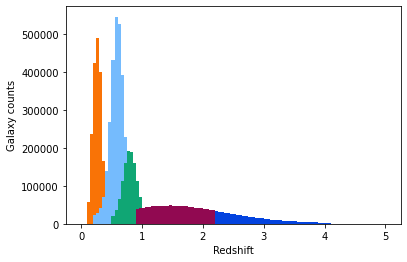

Source limits:
0.03
0.61
0.25
0.88
0.47
1.13
0.68
2.15
Lens limits:
0.11
0.63
0.26
0.78
0.39
0.93
0.51
1.09
0.63
1.21
0.71
1.31


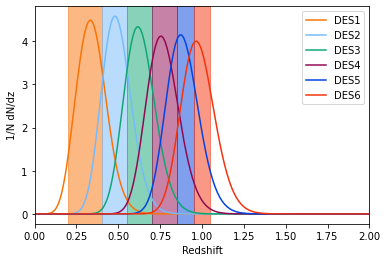

Parameter file done.


/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:1601: RuntimeWarning: invalid value encountered in double_scalars


Mean done.
h done.
As done.
ns done.
Omega_M done.
Omega_B done.
f_nu done.
N_eff done.
tau done.
w0 done.
wa done.
logT_AGN done.
b0 done.
b1 done.
b2 done.
b3 done.
b4 done.
c0 done.
c1 done.
c2 done.
c3 done.
c4 done.
alpha0 done.
alpha1 done.
alpha2 done.
alpha3 done.
alpha4 done.
NumDen0 done.
NumDen1 done.
NumDen2 done.
NumDen3 done.
NumDen4 done.
IA amplitude done.
IA tilt done.
Done.


In [2]:
#%%
########
# Main #
########


Zs=[]
# redshift scaling parameters
for i in range(0, 150):
	# For log time:
	Zs.append((np.exp((3./3.)-(3.*i/447.))) - 1)
# High redshift values
ZsHigh = []
ZsHigh.append(1200)
ZsHigh.append(1100)
# 4.5 - 999
for i in range(1, 140):
	scaleFactor = (i-0.6236)/376.4
	ZsHigh.append((1/scaleFactor)-1)
ZsHigh.append(0)

scaleFactorArray = []
for i in range(0, len(Zs)):
	scaleFactorArray.append(1/(Zs[i]+1))
for i in range(0, len(ZsHigh)-1):
	scaleFactorArray.append(1/(ZsHigh[i]+1))
scaleFactorArray.sort()



#########################
# INPUT FILE GENERATION #
#########################

# Calculates the transfer functions for forecasting
spectraForecasting(loZ=Zs, hiZ=ZsHigh, scaleFactor=scaleFactorArray, inputSuffix="Growth")
print("Done.")


In [3]:
#####################################
# GALAXY SELECTION FUNCTION TESTING #
#####################################

# Initial Parameters

redshiftFull = np.zeros(len(scaleFactorArray))
for i in range(len(redshiftFull)):
    redshiftFull[i] = (1./scaleFactorArray[len(scaleFactorArray)-i-1])-1.
redshift = redshiftFull[np.logical_and(redshiftFull<2.5, redshiftFull>0)]
# Y1 Source
#DESBinLimits = [0.2, 0.43, 0.63, 0.9, 1.3]
#DESBinZMed = 0.4
# Y3 Source
#DESBinLimits = [0.01, 0.36, 0.63, 0.87, 2.0]
#DESBinZMed = 0.75
# Y3 Lens
DESBinLimits = [0.2, 0.4, 0.55, 0.7, 0.85, 0.95, 1.05]
DESBinZMed = 0.5
EuclidBinLimits = [0.001, 0.42, 0.56, 0.68, 0.79, 0.90, 1.02, 1.15, 1.32, 1.58, 2.50]
EuclidBinZMed = 0.9*1.2/(2.**0.5)

zMed = DESBinZMed
BinLimits = DESBinLimits

cb = 1.0
zb = 0.0
sigmab = 0.05
co = 1.0
zo = 0.1
sigmao = 0.05
fout = 0.1
z0 = zMed/1.2

print(redshift)

[0.00673398 0.01351331 0.02033829 0.02720923 0.03412644 0.04109022
 0.04810091 0.0551588  0.06226422 0.06941749 0.07661892 0.08386885
 0.09116761 0.09851551 0.10591289 0.11336009 0.12085744 0.12840527
 0.13600393 0.14365376 0.1513551  0.1591083  0.16691372 0.17477169
 0.18268258 0.19064675 0.19866454 0.20673632 0.21486246 0.22304333
 0.23127928 0.23957069 0.24791793 0.25632139 0.26478144 0.27329845
 0.28187282 0.29050493 0.29919516 0.30794392 0.31675159 0.32561857
 0.33454526 0.34353206 0.35257938 0.36168763 0.37085721 0.38008853
 0.38938202 0.3987381  0.40815717 0.41763968 0.42718604 0.43679668
 0.44647204 0.45621256 0.46601867 0.47589081 0.48582943 0.49583498
 0.5059079  0.51604866 0.5262577  0.53653549 0.54688249 0.55729917
 0.56778599 0.57834344 0.58897197 0.59967208 0.61044424 0.62128894
 0.63220667 0.64319792 0.65426319 0.66540296 0.67661776 0.68790807
 0.69927441 0.71071729 0.72223723 0.73383474 0.74551035 0.75726459
 0.76909798 0.78101105 0.79300434 0.8050784  0.81723377 0.8294

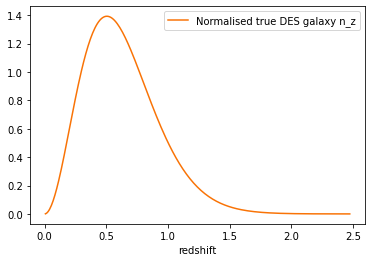

In [89]:
# True galaxy density distribution

nz = np.zeros(len(redshift))
for zz in range(len(redshift)):
    z = redshift[zz]
    exponent = -((z/z0)**1.5)
    nz[zz] = (z*z/(z0*z0))*np.exp(exponent)

numSpline = scipy.UnivariateSpline(redshift, nz, s=0)
numDenNormalisation = numSpline.integral(redshift[0], redshift[len(redshift)-1])

plt.plot(redshift, nz/numDenNormalisation, label="Normalised true DES galaxy n_z")
plt.xlabel("redshift")
plt.legend()
plt.show()

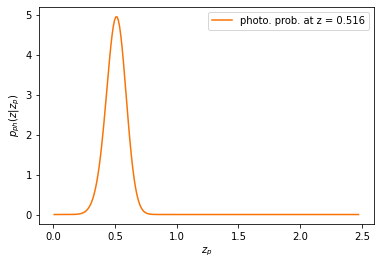

In [90]:
# Photometric probability distribution

photoProb = np.zeros((len(redshift), len(redshift)))
for zz in range(len(redshift)):
    zp = redshift[zz]
    for i in range(len(redshift)):
        z = redshift[i]
        ampDenom = (1+z)*((2.*np.pi)**0.5)
        probfin = (1-fout)/(sigmab*ampDenom)
        probfinExponent = ((z-(cb*zp)-zb)/(sigmab*(1+z)))**2.
        probfinexp = np.exp(-0.5*probfinExponent)
        probfout = (fout)/(sigmao*ampDenom)
        probfoutExponent = ((z-(co*zp)-zo)/(sigmao*(1+z)))**2.
        probfoutexp = np.exp(-0.5*probfoutExponent)
        photoProb[i][zz] = ((probfout*probfoutexp)+(probfin*probfinexp))

plt.plot(redshift, photoProb[61], label="photo. prob. at z = "+str(round(redshift[61], 3)))
plt.ylabel("$p_{ph}(z|z_p)$")
plt.xlabel("$z_p$")
plt.legend()
plt.show()

In [91]:
# Numerator integral of Euclid Preparation VII; eq. 112

integrand = np.zeros(len(redshift))
smearednz = np.zeros((len(BinLimits)-1, len(redshift)))
for i in range(len(BinLimits)-1):
    for zz in range(len(redshift)):
        for zp in range(len(redshift)):
            integrand[zp] = nz[zz] * photoProb[zz][zp]
        smearednz[i][zz] = scipy.UnivariateSpline(redshift, integrand, s=0).integral(BinLimits[i], BinLimits[i+1])

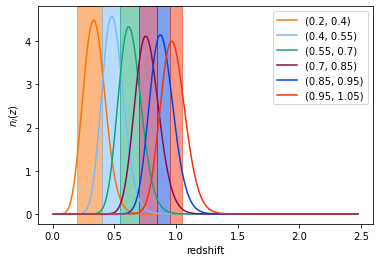

In [92]:
# Normalisation of Euclid Preparation VII; eq. 112

normSmearednz = np.zeros((len(BinLimits)-1, len(redshift)))
for binNum in range(len(BinLimits)-1):
    for zz in range(len(redshift)):
        smearedNormSpline = scipy.UnivariateSpline(redshift, smearednz[binNum], s=0)
        normSmearednz[binNum][zz] = smearednz[binNum][zz]/smearedNormSpline.integral(redshift[0], redshift[len(redshift)-1])
        
for binNum in range(len(BinLimits)-1):
    p = plt.plot(redshift, normSmearednz[binNum], label="("+str(BinLimits[binNum])+", "+str(BinLimits[binNum+1])+")")
    plt.axvspan(BinLimits[binNum], BinLimits[binNum+1], alpha=0.5, color=p[-1].get_color())
plt.xlabel("redshift")
plt.ylabel("$n_i(z)$")
plt.legend()
plt.show()


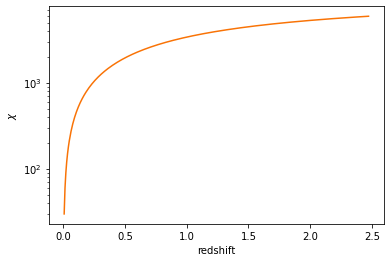

In [74]:
# Calculating radial geodesic distance (chi)

# Parameters
MEGA_PARSEC = 1.0
SPEED_OF_LIGHT_H0 = 299792.458
H_0 = 100./(MEGA_PARSEC*SPEED_OF_LIGHT_H0)

# Calculation
# load in previously calculated H(a)*a^2/H_0 to save time with CAMB
a2H = np.loadtxt(FILEPATH + "/InputFiles/Forecasting/a2Hubble1pt0DevMean.dat");
a2H = a2H*H_0   # Normalise
chiIntegrand = 1.0/a2H      # Integrand
chi = np.zeros(len(scaleFactorArray))
chiSpline = scipy.UnivariateSpline(scaleFactorArray, chiIntegrand, s=0)
for i in range(len(scaleFactorArray)):
    chi[i] = chiSpline.integral(scaleFactorArray[i], 1)     # Integrate over scale factor
chi = np.sort(chi)
chi = chi[np.logical_and(redshiftFull<2.5, redshiftFull>0)]

plt.plot(redshift, chi)
plt.xlabel("redshift")
plt.ylabel("$\chi$")
plt.yscale("log")
plt.show()

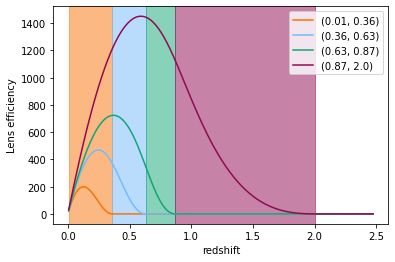

In [75]:
# Lensing efficiency kernel

lensEfficiency = np.zeros((len(BinLimits), len(redshift)))
for binNum in range(len(BinLimits)-1):
    for zz in range(len(redshift)):
        lensEffIntegrand = np.zeros(len(redshift))
        for i in range(len(redshift)):
            lensEffIntegrand[i] = normSmearednz[binNum][i]*(1.-(chi[zz]/chi[i]))    # Integrand
        lensEffSpline = scipy.UnivariateSpline(redshift, lensEffIntegrand, s=0)
        if(redshift[zz]<BinLimits[binNum+1]):
            lensEfficiency[binNum][zz] = (1+redshift[zz])*chi[zz]*lensEffSpline.integral(redshift[zz], BinLimits[binNum+1])
        else:
            lensEfficiency[binNum][zz] = 0

for binNum in range(len(BinLimits)-1):
    p = plt.plot(redshift, lensEfficiency[binNum], label="("+str(BinLimits[binNum])+", "+str(BinLimits[binNum+1])+")")
    plt.axvspan(BinLimits[binNum], BinLimits[binNum+1], alpha=0.5, color=p[-1].get_color())
plt.xlabel("redshift")
plt.ylabel("Lens efficiency")
plt.legend()
plt.show()

In [4]:
# Function generating DES selection function
# Redefine from previous function, allowing for immediate edits

def DESSelectionFunctionTEST(redshift, zLo, zHi, zMed, cb=1.0, zb=0.0, sigmab=0.05, co=1.0, zo=0.1, sigmao = 0.05, fout=0.1):
    z0 = zMed/1.2
    nz = np.zeros(len(redshift))
    for zz in range(len(redshift)):
        z = redshift[zz]
        exponent = -((z/z0)**1.5)
        nz[zz] = (z*z/(z0*z0))*np.exp(exponent)
    integrand = np.zeros(len(redshift))
    numDenIntegral = np.zeros(len(redshift))
    
    for zz in range(len(redshift)):
        z = redshift[zz]
        ampDenom = (1+z)*((2.*np.pi)**0.5)
        for i in range(len(redshift)):
            zp = redshift[i]
            probfin = (1-fout)/(sigmab*ampDenom)
            probfinExponent = ((z-(cb*zp)-zb)/(sigmab*(1+z)))**2.
            probfinexp = np.exp(-0.5*probfinExponent)
            probfout = (fout)/(sigmao*ampDenom)
            probfoutExponent = ((z-(co*zp)-zo)/(sigmao*(1+z)))**2.
            probfoutexp = np.exp(-0.5*probfoutExponent)
            integrand[i] = nz[zz]*((probfout*probfoutexp)+(probfin*probfinexp))
        numSpline = scipy.UnivariateSpline(redshift, integrand, s=0)
        numDenIntegral[zz] = numSpline.integral(zLo, zHi)
    numDenSpline = scipy.UnivariateSpline(redshift, numDenIntegral, s=0)
    selecFunc = numDenIntegral/numDenSpline.integral(redshift[0], redshift[len(redshift)-1])
    for zz in range(len(selecFunc)):
        if(abs(selecFunc[zz])<(10**(-300))):
            selecFunc[zz]=0
    return selecFunc

cb = 1.0
zb = 0.0
sigmab = 0.05
co = 1.0
zo = 0.1
sigmao = 0.05
fout = 0.1
cbDev = 0.1
coDev = 0.1
zbDev = 0.01
zoDev = 0.01
sigmabDev = 0.005
sigmaoDev = 0.005
foutDev = 0.01

In [5]:
# Vary each parameter for photo-z smearing by its deviation
# Note: sigmaz is varying both sigmab and sigmao

selecDeriv = np.zeros((8, 2, len(BinLimits)-1, len(redshift)))
paramIndx = ["cb", "co", "zb", "zo", "sigmab", "sigmao", "fout"]
paramIndx = ["cb", "co", "zb", "zo", "sigmab", "sigmao", "fout", "sigmaz"]
for binNum in range(len(BinLimits)-1):
    selecDeriv[0][0][binNum] = DESSelectionFunctionTEST(redshift=redshift, zLo=BinLimits[binNum], zHi=BinLimits[binNum+1], zMed=zMed, cb=cb+cbDev)
    selecDeriv[0][1][binNum] = DESSelectionFunctionTEST(redshift=redshift, zLo=BinLimits[binNum], zHi=BinLimits[binNum+1], zMed=zMed, cb=cb-cbDev)
    selecDeriv[1][0][binNum] = DESSelectionFunctionTEST(redshift=redshift, zLo=BinLimits[binNum], zHi=BinLimits[binNum+1], zMed=zMed, co=co+cbDev)
    selecDeriv[1][1][binNum] = DESSelectionFunctionTEST(redshift=redshift, zLo=BinLimits[binNum], zHi=BinLimits[binNum+1], zMed=zMed, co=co-cbDev)
    selecDeriv[2][0][binNum] = DESSelectionFunctionTEST(redshift=redshift, zLo=BinLimits[binNum], zHi=BinLimits[binNum+1], zMed=zMed, zb=zb+zbDev)
    selecDeriv[2][1][binNum] = DESSelectionFunctionTEST(redshift=redshift, zLo=BinLimits[binNum], zHi=BinLimits[binNum+1], zMed=zMed, zb=zb-zbDev)
    selecDeriv[3][0][binNum] = DESSelectionFunctionTEST(redshift=redshift, zLo=BinLimits[binNum], zHi=BinLimits[binNum+1], zMed=zMed, zo=zo+zoDev)
    selecDeriv[3][1][binNum] = DESSelectionFunctionTEST(redshift=redshift, zLo=BinLimits[binNum], zHi=BinLimits[binNum+1], zMed=zMed, zo=zo-zoDev)
    selecDeriv[4][0][binNum] = DESSelectionFunctionTEST(redshift=redshift, zLo=BinLimits[binNum], zHi=BinLimits[binNum+1], zMed=zMed, sigmab=sigmab+sigmabDev)
    selecDeriv[4][1][binNum] = DESSelectionFunctionTEST(redshift=redshift, zLo=BinLimits[binNum], zHi=BinLimits[binNum+1], zMed=zMed, sigmab=sigmab-sigmabDev)
    selecDeriv[5][0][binNum] = DESSelectionFunctionTEST(redshift=redshift, zLo=BinLimits[binNum], zHi=BinLimits[binNum+1], zMed=zMed, sigmao=sigmao+sigmaoDev)
    selecDeriv[5][1][binNum] = DESSelectionFunctionTEST(redshift=redshift, zLo=BinLimits[binNum], zHi=BinLimits[binNum+1], zMed=zMed, sigmao=sigmao-sigmaoDev)
    selecDeriv[6][0][binNum] = DESSelectionFunctionTEST(redshift=redshift, zLo=BinLimits[binNum], zHi=BinLimits[binNum+1], zMed=zMed, fout=fout+foutDev)
    selecDeriv[6][1][binNum] = DESSelectionFunctionTEST(redshift=redshift, zLo=BinLimits[binNum], zHi=BinLimits[binNum+1], zMed=zMed, fout=fout-foutDev)
    selecDeriv[7][0][binNum] = DESSelectionFunctionTEST(redshift=redshift, zLo=BinLimits[binNum], zHi=BinLimits[binNum+1], zMed=zMed, sigmab=sigmab+sigmabDev, sigmao=sigmao+sigmaoDev)
    selecDeriv[7][1][binNum] = DESSelectionFunctionTEST(redshift=redshift, zLo=BinLimits[binNum], zHi=BinLimits[binNum+1], zMed=zMed, sigmab=sigmab-sigmabDev, sigmao=sigmao-sigmaoDev)
    print("bin " + str(binNum) + " computed.")

bin 0 computed.
bin 1 computed.
bin 2 computed.
bin 3 computed.
bin 4 computed.
bin 5 computed.


In [15]:
# Plot deviations

fig = plt.figure(figsize=(12,9), dpi=1200)
ax = fig.add_subplot(111)
gs = fig.add_gridspec(2, 3, hspace=0, wspace=0)
axs = gs.subplots(sharex='col', sharey='row')
for i in range(8):
    p = axs[0,0].plot(redshift, selecDeriv[i][0][0], '--', label=paramIndx[i]+"-", alpha=0.7)
    axs[0,0].plot(redshift, selecDeriv[i][1][0], label=paramIndx[i]+"+", color=p[-1].get_color(), alpha=0.7)
    p = axs[0,1].plot(redshift, selecDeriv[i][0][1], '--', label=paramIndx[i]+"-", alpha=0.7)
    axs[0,1].plot(redshift, selecDeriv[i][1][1], label=paramIndx[i]+"+", color=p[-1].get_color(), alpha=0.7)
    p = axs[0,2].plot(redshift, selecDeriv[i][0][2], '--', label=paramIndx[i]+"-", alpha=0.7)
    axs[0,2].plot(redshift, selecDeriv[i][1][2], label=paramIndx[i]+"+", color=p[-1].get_color(), alpha=0.7)
    p = axs[1,0].plot(redshift, selecDeriv[i][0][3], '--', label=paramIndx[i]+"-", alpha=0.7)
    axs[1,0].plot(redshift, selecDeriv[i][1][3], label=paramIndx[i]+"+", color=p[-1].get_color(), alpha=0.7)
    p = axs[1,1].plot(redshift, selecDeriv[i][0][4], '--', label=paramIndx[i]+"-", alpha=0.7)
    axs[1,1].plot(redshift, selecDeriv[i][1][4], label=paramIndx[i]+"+", color=p[-1].get_color(), alpha=0.7)
    p = axs[1,2].plot(redshift, selecDeriv[i][0][5], '--', label=paramIndx[i]+"-", alpha=0.7)
    axs[1,2].plot(redshift, selecDeriv[i][1][5], label=paramIndx[i]+"+", color=p[-1].get_color(), alpha=0.7)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set(xlabel="redshift", ylabel=("$ n(z) $"))
axs[0,2].legend()
plt.show()

In [55]:
# Functions for making transfer function graphs and Runge-Kutta

# retrieve data given neutrino fraction
def cosmoChange(fnu, Zs, hierarchy='degenerate'):
    h = 0.675
    ommh2 = 0.144
    Mass = 93.14 * fnu * ommh2
    omnuh2 = Mass / 93.14
    print('Total neutrino mass is %f eV' %(Mass))
    if omnuh2 <= 0.122:
        pars = camb.CAMBparams()
        pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122-omnuh2, neutrino_hierarchy=hierarchy, num_massive_neutrinos=3, mnu=Mass, nnu=3.046, meffsterile=0.0, standard_neutrino_neff=3.046, omk=0, tau=0.06)
    else:
        print('omnu greater than omc.')
        pars = camb.CAMBparams()
        omnuh2=0.06/93.14
        pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122-omnuh2, neutrino_hierarchy='degenerate', num_massive_neutrinos=3, mnu=0.00, nnu=3.046, meffsterile=0.0, standard_neutrino_neff=3.046, omk=0, tau=0.06)
    pars.set_matter_power(redshifts=Zs, kmax=10, k_per_logint=50, nonlinear=None, accurate_massive_neutrino_transfers=True, silent=False)
    params = camb.CAMBdata()
    params.set_params(pars)
    params.calc_transfers(pars)
    data = params.get_matter_transfer_data()
    params.calc_background(pars)
    H_of_z = params.hubble_parameter(Zs)
    Pk = camb.get_matter_power_interpolator(pars, nonlinear=False, hubble_units=False, k_hunit=True)
    return data, H_of_z, Pk

# RK4 solution
def RK4(OmM=0.144/(0.675*0.675), w0=-1.0, wa=0.0, da=0.001, ai=0.001, af=1.0):
    Darr = []
    A = []
    D = ai
    s = 1
    a = ai
    Darr.append(D)
    A.append(a)
    while(a<(ai*10)):
        Dnew, snew = RK4Alg(a0=a, da=da/10, w0=w0, wa=wa, OmM=OmM, D=D, s=s)
        D = Dnew
        s = snew
        a = a+(da/10)
        Darr.append(D)
        A.append(a)
    while(a<af):
        Dnew, snew = RK4Alg(a0=a, da=da, w0=w0, wa=wa, OmM=OmM, D=D, s=s)
        D = Dnew
        s = snew
        a = a+da
        Darr.append(D)
        A.append(a)
    return Darr, A

# RK4 algorithm
def RK4Alg(a0, da, w0, wa, OmM, D, s):
    q10 = D
    q20 = s
    a1 = a0+(da/2.)
    a2 = a0+da
    # k^(0)
    K11 = RK4evalA(q1=q10, q2=q20, a=a0)
    q11 = q10 + (K11 * da/2.)
    K21 = RK4evalB(q1=q10, q2=q20, a=a0, D=q10, s=q20, w0=w0, wa=wa, OmM=OmM)
    q21 = q20 + (K21 * da/2.)
    # k^(2)
    K12 = RK4evalA(q1=q11, q2=q21, a=a1)
    q12 = q10 + (K12 * da/2.)
    K22 = RK4evalB(q1=q11, q2=q21, a=a1, D=q11, s=q21, w0=w0, wa=wa, OmM=OmM)
    q22 = q20 + (K22 * da/2.)
    # k^(3)
    K13 = RK4evalA(q1=q12, q2=q22, a=a1)
    q13 = q10 + (K13 * da)
    K23 = RK4evalB(q1=q12, q2=q22, a=a1, D=q12, s=q22, w0=w0, wa=wa, OmM=OmM)
    q23 = q20 + (K23 * da)
    # k^(4)
    K14 = RK4evalA(q1=q13, q2=q23, a=a2)
    q14 = q10 + (K14 * da)
    K24 = RK4evalB(q1=q13, q2=q23, a=a2, D=q13, s=q23, w0=w0, wa=wa, OmM=OmM)
    q24 = q20 + (K24 * da)
    # Estimates
    Dest = D + (K11 + 2*K12 + 2*K13 + K14)*(da/6.)
    sest = s + (K21 + 2*K22 + 2*K23 + K24)*(da/6.)
    return Dest, sest

def RK4evalA(q1, q2, a):
    return q2

def RK4evalB(q1, q2, a, D, s, w0, wa, OmM):
    G1 = RK4evalG1(q1=q1, q2=q2, a=a, D=D, s=s, w0=w0, wa=wa, OmM=OmM)
    G2 = RK4evalG2(q1=q1, q2=q2, a=a, D=D, s=s, OmM=OmM)
    B = - (G1*q2) + (G2*q1)
    return B

def RK4evalG1(q1, q2, a, D, s, w0, wa, OmM):
    H2 = (OmM/(a**3.))+(1-OmM)
    B1 = 2 - (((OmM/(a**3.))-2*(1-OmM))/(2*H2))
    G1 = B1/a
    return G1

def RK4evalG2(q1, q2, a, OmM, D, s):
    H2 = (OmM/(a**3.)) + (1-OmM)
    B2 = (OmM/(a*a*a*H2))
    G2 = 3*B2/(2*a*a)
    return G2

##################################


# RK4 with explicit neutrino fraction
def RK4fnu(fnu, OmM=0.144/(0.675*0.675), OmB=0.022/(0.675*0.675), h=0.675, w0=-1.0, wa=0.0, da=0.001, ai=0.001, af=1.0):
    #OmC=OmM*(1-fnu) - OmB
    OmC=OmM
    aHfunc = ai
    H = []
    aH = []
    aH.append(aHfunc)
    while(aHfunc<(ai*10)):
        H.append(RK4Hfunc(a=aHfunc, w0=w0, wa=wa, OmM=OmM))
        aHfunc = aHfunc+(da/10)
        aH.append(aHfunc)
    while(aHfunc<af):
        H.append(RK4Hfunc(a=aHfunc, w0=w0, wa=wa, OmM=OmM))
        aHfunc = aHfunc+da
        aH.append(aHfunc)
    H.append(RK4Hfunc(a=aHfunc, w0=w0, wa=wa, OmM=OmM))
    Hfunc = scipy.UnivariateSpline(aH, H, s=0)
    Hdotfunc = Hfunc.derivative(n=1)
    Darr = []
    sarr = []
    A = []
    D = ai
    s = 1.0
    a = ai
    Darr.append(D)
    A.append(a)
    sarr.append(s)
    while(a<(ai*10)):
        Dnew, snew = RK4Algfnu(a0=a, da=da/10, fnu=fnu, OmC=OmC, D=D, s=s, Hfunc=Hfunc, Hdotfunc=Hdotfunc)
        D = Dnew
        s = snew
        a = a+(da/10)
        Darr.append(D)
        sarr.append(s)
        A.append(a)
    while(a<af):
        Dnew, snew = RK4Algfnu(a0=a, da=da, fnu=fnu, OmC=OmC, D=D, s=s, Hfunc=Hfunc, Hdotfunc=Hdotfunc)
        D = Dnew
        s = snew
        a = a+da
        Darr.append(D)
        sarr.append(s)
        A.append(a)
    return Darr, sarr, A

# RK4 algorithm
def RK4Algfnu(a0, da, fnu, OmC, D, s, Hfunc, Hdotfunc):
    q10 = D
    q20 = s
    a1 = a0+(da/2.)
    a2 = a0+da
    # k^(0)
    K11 = RK4evalAfnu(q1=q10, q2=q20, a=a0)
    q11 = q10 + (K11 * da/2.)
    K21 = RK4evalBfnu(q1=q10, q2=q20, a=a0, fnu=fnu, OmC=OmC, Hfunc=Hfunc, Hdotfunc=Hdotfunc)
    q21 = q20 + (K21 * da/2.)
    # k^(2)
    K12 = RK4evalAfnu(q1=q11, q2=q21, a=a1)
    q12 = q10 + (K12 * da/2.)
    K22 = RK4evalBfnu(q1=q11, q2=q21, a=a1, fnu=fnu, OmC=OmC, Hfunc=Hfunc, Hdotfunc=Hdotfunc)
    q22 = q20 + (K22 * da/2.)
    # k^(3)
    K13 = RK4evalAfnu(q1=q12, q2=q22, a=a1)
    q13 = q10 + (K13 * da)
    K23 = RK4evalBfnu(q1=q12, q2=q22, a=a1, fnu=fnu, OmC=OmC, Hfunc=Hfunc, Hdotfunc=Hdotfunc)
    q23 = q20 + (K23 * da)
    # k^(4)
    K14 = RK4evalAfnu(q1=q13, q2=q23, a=a2)
    q14 = q10 + (K14 * da)
    K24 = RK4evalBfnu(q1=q13, q2=q23, a=a2, fnu=fnu, OmC=OmC, Hfunc=Hfunc, Hdotfunc=Hdotfunc)
    q24 = q20 + (K24 * da)
    # Estimates
    Dest = D + (K11 + 2*K12 + 2*K13 + K14)*(da/6.)
    sest = s + (K21 + 2*K22 + 2*K23 + K24)*(da/6.)
    return Dest, sest

def RK4evalAfnu(q1, q2, a):
    return q2

def RK4evalBfnu(q1, q2, a, fnu, OmC, Hfunc, Hdotfunc):
    H=Hfunc(a)
    Hdot=Hdotfunc(a)
    G1 = RK4evalG1fnu(a=a, H=H, Hdot=Hdot)
    G2 = RK4evalG2fnu(a=a, H=H, fnu=fnu, OmC=OmC)
    B = - (G1*q2) + (G2*q1)
    return B

def RK4evalG1fnu(a, H, Hdot):
    G1 = (3/a) + (Hdot/H)
    return G1

def RK4evalG2fnu(a, H, fnu, OmC):
    H2 = H*H
    B = (OmC*(1-fnu)/(a*a*a*H2))
    G2 = 3*B/(2*a*a)
    return G2

def RK4Hfunc(a, w0, wa, OmM):
    return ((OmM/(a*a*a)) + ((1-OmM)*RK4DEfnu(a=a, w0=w0, wa=wa)/(a**3.)))**0.5

def RK4DEfnu(a, w0, wa):
    return (a**(-3.*(w0+wa)))*np.exp(3*wa*(a-1))

def set_pub():      # Publication function for nice-looking graphs
    plt.rcParams.update({
        "font.size": 20,        # font size
        "figure.figsize":(9, 8),# figure size
        "lines.linewidth": 2,
        "font.weight": "bold",  # bold fonts
        "text.usetex": True,
        "font.family": 'serif'
    })
    
set_pub()       # Set publication function

def normalise(array, normalisation):
    normalised_array = []
    for i in range(0, len(array)):
        normalised_array.append(array[i]/normalisation)
        normalised_array[i]=abs(normalised_array[i])
    return normalised_array

def CPTSolution(ai, af=1.0, OmM0=0.144/(0.675*0.675)):      # Carol-Press-Turner Solution
    H2i = (OmM0/(ai*ai*ai))+(1-OmM0)
    OmMi = OmM0/(ai*ai*ai*H2i)
    OmLi = (1-OmM0)/H2i
    B1i = OmMi**(4./7.)
    B2i = -OmLi
    B3i = (1+(OmMi/2))*(1+(OmLi/70))
    Fi = B1i+B2i+B3i
    gi = 5*OmMi/(2*Fi)
    H2f = (OmM0/(af*af*af))+(1-OmM0)
    OmMf = OmM0/(af*af*af*H2f)
    OmLf = (1-OmM0)/H2f
    B1f = OmMf**(4./7.)
    B2f = -OmLf
    B3f = (1+(OmMf/2))*(1+(OmLf/70))
    Ff = B1f+B2f+B3f
    gf = 5*OmMf/(2*Ff)
    CPT = gf/gi
    return ai*gi

Total neutrino mass is 0.200000 eV
Total neutrino mass is 0.200000 eV
[-5.28341560e-03 -3.52723896e-03 -1.77600243e-03 ...  5.07493782e+01
  5.46935583e+01  5.94789094e+01]


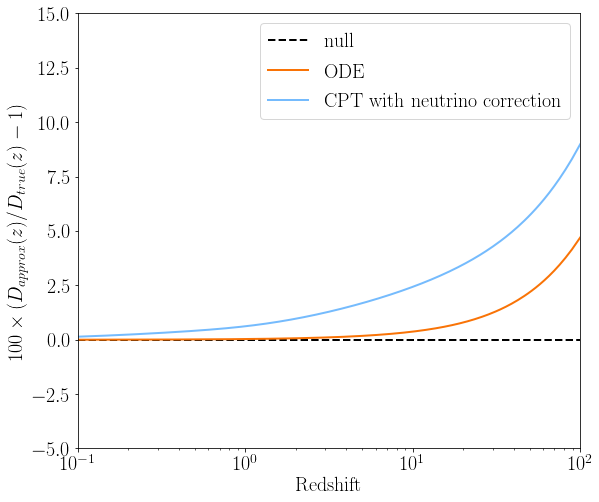

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -6.89423341e-06  6.62504749e-06 ... -1.64776078e+01
  -1.64774130e+01 -1.64791342e+01]
 [ 0.00000000e+00 -9.63788356e-06 -8.32945379e-06 ... -3.30135605e+01
  -3.30162292e+01 -3.30172330e+01]
 [ 0.00000000e+00 -6.28508476e-06 -1.42821112e-05 ... -4.96083084e+01
  -4.96081107e+01 -4.96102212e+01]
 [ 0.00000000e+00 -1.76587386e-05 -4.06092653e-05 ... -6.62610770e+01
  -6.62665275e+01 -6.62635255e+01]]


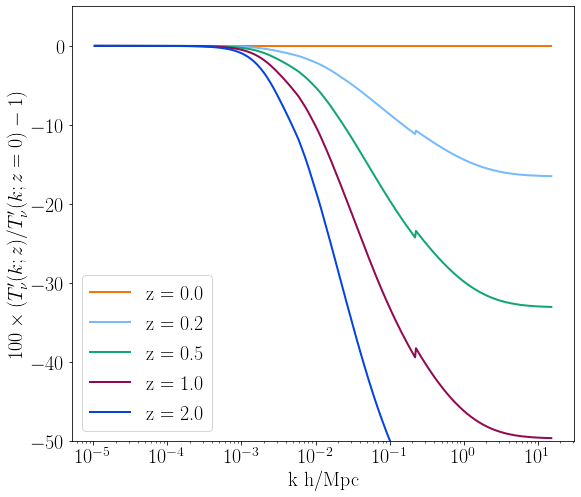

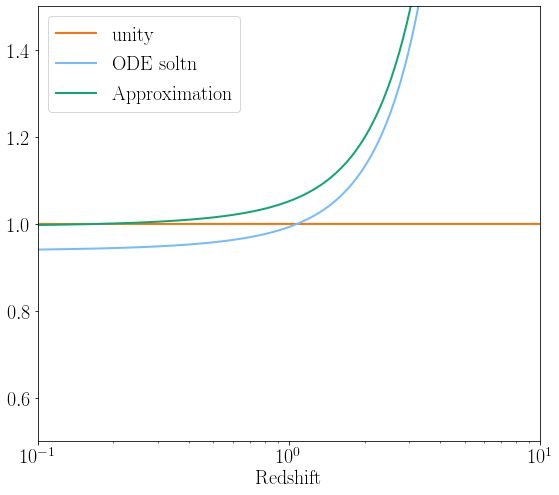

In [62]:
# Transfer function graphs and growth function approximation graphs

Zs=[]
# redshift scaling parameters
for i in range(0, 150):
	# For log time:
	Zs.append((np.exp((3./3.)-(3.*i/447.))) - 1)
# High redshift values
ZsHigh = []
ZsHigh.append(1200)
ZsHigh.append(1100)
# 4.5 - 999
for i in range(1, 140):
	scaleFactor = (i-0.6236)/376.4
	ZsHigh.append((1/scaleFactor)-1)
ZsHigh.append(0)

scaleFactorArray = []
for i in range(0, len(Zs)):
	scaleFactorArray.append(1/(Zs[i]+1))
for i in range(0, len(ZsHigh)-1):
	scaleFactorArray.append(1/(ZsHigh[i]+1))
scaleFactorArray.sort()

FNu = 0.2/(93.14*0.144)
dat, dat_H_of_z, Pk = cosmoChange(fnu=FNu, Zs=Zs, hierarchy='degenerate')
datHighZ, datHighZ_H_of_z, PkHighZ = cosmoChange(fnu=FNu, Zs=ZsHigh, hierarchy='degenerate')
Tm = []
Tc = []
Tn = []
Tb = []
FullZs = []
for i in range(len(ZsHigh)-1):
    Tc.append((datHighZ.transfer_z(name='delta_cdm', z_index=i)))#*(ZsHigh[i]+1))
    Tn.append((datHighZ.transfer_z(name='delta_nu', z_index=i)))#*(ZsHigh[i]+1))
    Tm.append(datHighZ.transfer_z(name='delta_tot', z_index=i))
    Tb.append(datHighZ.transfer_z(name='delta_baryon', z_index=i))
    FullZs.append(ZsHigh[i])
for i in range(len(Zs)):
    Tc.append((dat.transfer_z(name='delta_cdm', z_index=i)))#*(Zs[i]+1))
    Tn.append((dat.transfer_z(name='delta_nu', z_index=i)))#*(Zs[i]+1))
    Tm.append(dat.transfer_z(name='delta_tot', z_index=i))
    Tb.append(dat.transfer_z(name='delta_baryon', z_index=i))
    kk = dat.transfer_z(name='k/h', z_index=0)
    FullZs.append(Zs[i])
    
D, a = RK4()
fNu = 0.2/(93.14*0.144)
Dfnu, sfnu, afnu = RK4fnu(fnu=fNu)
DNfnu, sNfnu, aNfnu = RK4fnu(fnu=0)
Da = normalise(array=D, normalisation=D[len(D)-1])
DaCPT = np.zeros((len(Da)))
for i in range(len(a)):
    DaCPT[i] = CPTSolution(ai=a[i], af=1.0, OmM0=0.144/(0.675*0.675))**(1.-(3.*fNu/5.))
DCPT = normalise(array=DaCPT, normalisation=DaCPT[len(DaCPT)-1])

Tcdm = [*zip(*normalise(array=Tc, normalisation=Tc[len(Tc)-1]))][0]
Tnu = [*zip(*normalise(array=Tn, normalisation=Tn[len(Tn)-1]))][0]
Tmat = [*zip(*normalise(array=Tm, normalisation=Tm[len(Tm)-1]))][0]
Tbar = [*zip(*normalise(array=Tb, normalisation=Tb[len(Tb)-1]))][0]

TCDM = scipy.UnivariateSpline(scaleFactorArray, Tcdm, s=0)(a)
TM = scipy.UnivariateSpline(scaleFactorArray, Tmat, s=0)(a)
TN = scipy.UnivariateSpline(scaleFactorArray, Tnu, s=0)(a)
TB = scipy.UnivariateSpline(scaleFactorArray, Tbar, s=0)(a)

redshift = np.zeros(len(a))
DaComparison = np.zeros(len(a))
DafnuComparison = np.zeros(len(a))
null = np.zeros(len(a))
for i in range(len(redshift)):
    redshift[i] = (1./a[len(a)-i-1]) - 1
    DaComparison[i] = 100*((Da[i]/TCDM[i]) - 1)
    DafnuComparison[i] = 100*((DCPT[i]/TCDM[i]) - 1)
    

DaComparison = np.flip(DaComparison)    
DafnuComparison = np.flip(DafnuComparison)
print(DafnuComparison)


plt.plot(redshift, null, "--", color="k", label="null")
plt.plot(redshift, DaComparison, label="ODE")
plt.plot(redshift, DafnuComparison, label="CPT with neutrino correction")
plt.xscale('log')
plt.xlabel("Redshift")
plt.ylabel("$100 \\times (D_{approx}(z) / D_{true}(z) - 1)$")
plt.xlim([0.1, 100])
plt.ylim([-5, 15])
plt.legend()
plt.savefig(FILEPATH+"/Graphs/GrowthFunctionApproximation.png")
plt.show()

PotRatio = []
PotRatioPrime = []
Unity = []
Unity.append(1.0)
PotRatio.append(1.0)
PotRatioPrime.append(1.0)
potZ = []
potZ.append((1/a[0])-1)
for i in range(1, len(Dfnu)):
    exponent = 1-(3*fNu/5)
    B1 = (Dfnu[i] - (afnu[i]*sfnu[i])) / (DNfnu[i] - (aNfnu[i]*sNfnu[i]))
    B2 = 1 - ((fNu)/(0.122/0.144))
    B1prime = ((DNfnu[i]**exponent) - (aNfnu[i]*exponent*sNfnu[i]*(DNfnu[i]**(exponent-1)))) / (DNfnu[i] - (aNfnu[i]*sNfnu[i]))
    B2prime = 1 - ((fNu)/(0.122/0.144))
    PotRatio.append(B1*B2)
    PotRatioPrime.append(B1prime*B2prime)
    potZ.append((1/a[i])-1)
    Unity.append(1.0)

    
TCold = np.zeros((len(FullZs), len(kk)))
TMatter = np.zeros((len(FullZs), len(kk)))
TNeutrino = np.zeros((len(FullZs), len(kk)))
TBaryon = np.zeros((len(FullZs), len(kk)))
for i in range(len(FullZs)):
    TCold[i] = Tc[len(FullZs)-i-1]
    TMatter[i] = Tm[len(FullZs)-i-1]
    TBaryon[i] = Tb[len(FullZs)-i-1]
    TNeutrino[i] = Tn[len(FullZs)-i-1]
    
FullZs = np.flip(FullZs)
    
PlottingZs = np.array([0, 0.2, 0.5, 1.0, 2.0])
TCold = np.transpose(TCold)
TMatter = np.transpose(TMatter)
TBaryon = np.transpose(TBaryon)
TNeutrino = np.transpose(TNeutrino)
ColdComparison = np.zeros((len(PlottingZs), len(kk)))
MatterComparison = np.zeros((len(PlottingZs), len(kk)))
BaryonComparison = np.zeros((len(PlottingZs), len(kk)))
NeutrinoComparison = np.zeros((len(PlottingZs), len(kk)))
Cold = np.transpose(np.zeros((len(PlottingZs), len(kk))))
Matter = np.transpose(np.zeros((len(PlottingZs), len(kk))))
Baryon = np.transpose(np.zeros((len(PlottingZs), len(kk))))
Neutrino = np.transpose(np.zeros((len(PlottingZs), len(kk))))
for i in range(len(kk)):
    Cold[i] = scipy.UnivariateSpline(FullZs, TCold[i], s=0)(PlottingZs)
    Matter[i] = scipy.UnivariateSpline(FullZs, TMatter[i], s=0)(PlottingZs)
    Baryon[i] = scipy.UnivariateSpline(FullZs, TBaryon[i], s=0)(PlottingZs)
    Neutrino[i] = scipy.UnivariateSpline(FullZs, TNeutrino[i], s=0)(PlottingZs)
    
Cold = Cold/Cold[0]
Matter = Matter/Matter[0]
Baryon = Baryon/Baryon[0]
Neutrino = Neutrino/Neutrino[0]
Cold = np.transpose(Cold)
Matter = np.transpose(Matter)
Baryon = np.transpose(Baryon)
Neutrino = np.transpose(Neutrino)
    
ColdComparison = 100*((Cold/Cold[0])-1)
MatterComparison = 100*((Matter/Matter[0])-1)
BaryonComparison = 100*((Baryon/Baryon[0])-1)
NeutrinoComparison = 100*((Neutrino/Neutrino[0])-1)
print(NeutrinoComparison)
    
for i in range(len(PlottingZs)):
    plt.plot(kk, NeutrinoComparison[i], label="z = "+str(PlottingZs[i]))
plt.xscale("log")
plt.xlabel("k h/Mpc")
plt.ylabel("$100 \\times (T_{\\nu}'(k;z) / T_{\\nu}'(k;z=0) - 1)$")
plt.ylim([-50, 5])
plt.legend()
plt.savefig(FILEPATH+"/Graphs/NormalisedTransferNeutrino.png")
plt.show()
    
    
    
plt.plot(potZ, Unity, label="unity")
plt.plot(potZ, PotRatio, label="ODE soltn")
plt.plot(potZ, PotRatioPrime, label="Approximation")
plt.xlim([0.1, 10])
plt.ylim([0.5, 1.5])
plt.xscale('log')
plt.xlabel("Redshift")
plt.legend()
plt.show()